In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.copod import COPOD
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
import joblib
from scipy import stats
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
from scipy.stats import norm
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from string import ascii_uppercase
import seaborn as sn

# RGIs SELECIONADAS - CAPITAIS

In [60]:
df_RGIs = sorted([160001, 240001, 320001, 120001, 520001, 280001, 410001, 250001, 330001, 170001, 290001, 130001, 530001, 210001, 500001, 260001,
                  420001, 220001, 140001, 270001, 510001, 430001, 110001, 350001, 230001, 310001, 150001])


# Carrega DATASET

In [61]:
def carregarArq(caminho, separ):
    chunks = []
    dados_chunks = pd.DataFrame()
    for chunk in pd.read_csv(caminho, sep= separ, encoding = 'utf-8-sig', chunksize=200000):
        chunks.append(chunk)
    dados_chunks = pd.concat(chunks)
    return dados_chunks

In [62]:
# --------- LEITURA DO DADOS APS ---------------------
caminho = r'APS_FINAL_31_12_23 (1).csv'
df = carregarArq(caminho, ',')
display(df)

,municipio,co_ibge,ano,epiweek,atend_totais,atend_ivas,atend_arbov,cod_rgi,nome_rgi,co_ibge_7,uf_code,UF,longitude,latitude,pop_21,dqi
0,Alta Floresta D´oeste,110001,2017,12,615,15,0,110005,Cacoal,1100015,11,RO,-61.999824,-11.935540,22516,Apto
1,Alta Floresta D´oeste,110001,2017,15,497,13,0,110005,Cacoal,1100015,11,RO,-61.999824,-11.935540,22516,Apto
2,Alta Floresta D´oeste,110001,2018,17,338,11,0,110005,Cacoal,1100015,11,RO,-61.999824,-11.935540,22516,Apto
3,Alta Floresta D´oeste,110001,2018,23,333,12,0,110005,Cacoal,1100015,11,RO,-61.999824,-11.935540,22516,Apto
4,Alta Floresta D´oeste,110001,2018,44,601,16,0,110005,Cacoal,1100015,11,RO,-61.999824,-11.935540,22516,Apto
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033045,Brasília,530010,2017,41,1764,158,3,530001,Distrito Federal,5300108,53,DF,-47.887905,-15.794087,3094325,Apto
2033046,Brasília,530010,2020,30,55599,15840,776,530001,Distrito Federal,5300108,53,DF,-47.887905,-15.794087,3094325,Apto
2033047,Brasília,530010,2021,9,62834,12589,659,530001,Distrito Federal,5300108,53,DF,-47.887905,-15.794087,3094325,Apto
2033048,Brasília,530010,2022,6,83773,28220,1503,530001,Distrito Federal,5300108,53,DF,-47.887905,-15.794087,3094325,Apto


# FUNÇÕES PARA AGRUPAMENTO E DETECÇÃO

In [63]:
#---------------função agrupa dados RGI--------------------------
def filtraRGIs(df):

    DADOS_AGP = df.groupby(['cod_rgi','nome_rgi','UF','ano','epiweek'])['atend_ivas'].sum() # Para executar respiratória
    dataAGP = pd.DataFrame(DADOS_AGP)
    dataAGP.reset_index(inplace = True)

    return dataAGP



#---------------função agrupa dados Nacional--------------------------
def filtraNacional(df):

    nacional = df.groupby(['ano','epiweek'])['atend_ivas'].sum()
    dataAGP = pd.DataFrame(nacional)
    dataAGP.reset_index(inplace = True)

    return dataAGP



##------------------função RT----------------------------------
def calculo_rt(n, m, gamma, q, serie):
    rt = [0] * n
    w = [0.0] * (m + 1)

    for i in range(1, n + 1):
        deno = 0.0
        soma = 0.0
        ie = min(i, m)

        if ie > 1:
            ww = ((1 - q) ** 2) / (q * (1.0 + (ie - 1) * q ** ie - ie * q ** (ie - 1)))
            for j in range(1, ie + 1):
                w[j] = ww * (j - 1) * q ** (j - 1)
                deno += w[j] * serie[i - j]
                soma += w[j]

            if deno != 0:
                rt[i - 1] = soma * serie[i - 1] / deno

    return rt




#---------------ML-------------------------------------


def treina_Models_ensemble(data_T):
    
    # Configuração 1
    # cria os modelos Isolation Forest, Local Outilier Factory e One class SVM
    ISF = IsolationForest(n_estimators = 500, contamination=0.4)
    LOF = LocalOutlierFactor(n_neighbors = 500, contamination= 0.4)
    OCSVM = OneClassSVM(nu = 0.8, kernel='rbf', gamma=0.001)
    COPO = COPOD(contamination = 0.4)
    
    # Configuração 2
    # cria os modelos Isolation Forest, Local Outilier Factory e One class SVM
    #ISF = IsolationForest(n_estimators = 500, contamination=0.3)
    #LOF = LocalOutlierFactor(n_neighbors = 300, contamination= 0.3)
    #OCSVM = OneClassSVM(nu = 0.5, kernel='rbf', gamma=0.001)
    #COPO = COPOD(contamination = 0.3)

    ISF.fit(data_T)
    LOF.fit(data_T)
    OCSVM.fit(data_T)
    COPO.fit(data_T)
  

    return ISF, LOF, OCSVM, COPO

def executa_Models_ensemble(ISF, LOF, OCSVM, COPO, data_V):

    ISF_Pred = ISF.predict(data_V)
    LOF_Pred = LOF.fit_predict(data_V)
    OCSVM_Pred = OCSVM.predict(data_V)
    COPO_Pred = COPO.predict(data_V)

    for i in range(len(COPO_Pred)):

        if (COPO_Pred[i] == 1):
            COPO_Pred[i] = -1
        elif (COPO_Pred[i] == 0):
            COPO_Pred[i] = 1


    ENSEMBLE_Pred = ISF_Pred+LOF_Pred+OCSVM_Pred+COPO_Pred

    return ISF_Pred, LOF_Pred, OCSVM_Pred, COPO_Pred, ENSEMBLE_Pred

# Funções para calcular EARs C1, C2 e C3

In [64]:
# ---------------funções para calcular estatísticas EARS C1, C2 e C3 com limites --------------------------

def calculate_c1(observations, baseline,  alpha=0.05):
    c1_stats = np.full(len(observations), np.nan)  # Inicializa com NaN
    c1_alarms = np.full(len(observations), 0)
    c1_upper_bounds = np.full(len(observations), np.nan)  # Inicializa com NaN

    # Cálculo do quantil da distribuição normal padrão para um teste de uma cauda
    z_alpha = stats.norm.ppf(1 - alpha)
    
    for t in range(baseline, len(observations)):
        mean_baseline = np.mean(observations[t-baseline:t]) # Calcula a Média Móvel
        # Ajuste para usar o denominador específico da descrição
        std_baseline = np.sqrt(np.sum((observations[t-baseline:t] - mean_baseline)**2) / 6)  # Calcula o Desvio Padrão 

        # Prevenindo divisão por zero
        if std_baseline > 0:
            c1_stats[t] = (observations[t] - mean_baseline) / std_baseline # Calcula o C1
            c1_upper_bounds[t] = mean_baseline + z_alpha * std_baseline # Calcula o Limite crítico 
            c1_upper_bounds[t] = np.rint(c1_upper_bounds[t]).astype(int)

            # Condição para acionar o alarme
            if ((c1_stats[t] >= z_alpha) and (observations[t] > c1_upper_bounds[t])) :
                c1_alarms[t] = 1
            else:
                c1_alarms[t] = 0
                
        else:
            c1_stats[t] = 0

    return c1_stats, c1_alarms, c1_upper_bounds


def calculate_c2(observations, baseline, alpha=0.05):
    c2_stats = np.full(len(observations), np.nan)
    c2_alarms = np.full(len(observations), 0)
    c2_upper_bounds = np.full(len(observations), np.nan)

    z_alpha = stats.norm.ppf(1 - alpha)

    # Ajuste: O loop deve começar em 'baseline + 2'
    for t in range(baseline + 2, len(observations)):
        baseline_data = observations[t - baseline - 2:t - 2]
        mean_adjusted_baseline = np.mean(baseline_data)

        # Denominador atualizado para 'baseline - 1'
        std_adjusted_baseline = np.sqrt(np.sum((baseline_data - mean_adjusted_baseline) ** 2) / (baseline - 1))

        if std_adjusted_baseline > 0:
            c2_stats[t] = (observations[t] - mean_adjusted_baseline) / std_adjusted_baseline
            c2_upper_bounds[t] = mean_adjusted_baseline + z_alpha * std_adjusted_baseline
            c2_upper_bounds[t] = np.rint(c2_upper_bounds[t]).astype(int)

            if ((c2_stats[t] >= z_alpha) and (observations[t] > c2_upper_bounds[t])):
                c2_alarms[t] = 1
            else:
                c2_alarms[t] = 0
        else:
            c2_stats[t] = 0

    return c2_stats, c2_alarms, c2_upper_bounds




def calculate_c3(observations, baseline, alpha = 0.05):
    
    c3_stats = np.full(len(observations), np.nan)
    c3_alarms = np.full(len(observations), 0)
    c3_upper_bounds = np.full(len(observations), np.nan)
    
    
    # Calcula o quantil da distribuição normal padrão para um teste de duas caudas
    z_alpha = stats.norm.ppf(1 - alpha)

    # Precisamos primeiro calcular C2 para usar no cálculo de C3
    c2_stats, _, _ = calculate_c2(observations, baseline=baseline, alpha=alpha)  # Assume que calculate_c2 retorna c2_stats, c2_alarms, c2_upper_bounds

    for t in range(baseline + 4, len(observations)):
        # C3 é baseado nos valores de C2 do ponto atual (t) e dos dois pontos anteriores
        
        c3_stats[t] = sum(max(0, c2_stats[i] - 1) for i in range(t-2, t))
        # O limite superior para C3 é baseado na média e desvio padrão da linha de base de C2
        baseline_data = observations[t-baseline:t-4]        
        mean_adjusted_baseline = np.mean(baseline_data)
        
        std_adjusted_baseline = np.sqrt(np.sum((baseline_data - mean_adjusted_baseline) ** 2) / (baseline - 1))
        
        fator = (z_alpha - sum(max(0, c2_stats[i] - 1) for i in range(t-2, t)))
        
        # Define o limite superior para C3
        if std_adjusted_baseline > 0 and fator > 0:
            c3_upper_bounds[t] = mean_adjusted_baseline + std_adjusted_baseline * fator
        else:
            c3_upper_bounds[t] = 0
        
        # Se a estatística C3 for maior que o limite superior, um alarme é disparado
        if ((c3_stats[t] >= z_alpha) and (observations[t] >= c3_upper_bounds[t])):
            c3_alarms[t] = 1
        else:
            c3_alarms[t] = 0

    return c3_stats, c3_alarms, c3_upper_bounds

# Calcula limite aceitavel para o ponto.
* Obs: esse é auxilia na catalogação de surtos da série

In [65]:

def calculaLimite(data, janela):
    alpha = 0.05
    z_alpha = stats.norm.ppf(1 - alpha / 2) # define distribuição normal
    media_movel = np.convolve(data, np.ones(janela)/janela, mode='valid') # define a janela
    media_movel = np.concatenate(([media_movel[0]]*(janela-1), media_movel)) # Adiciona a media  móvel calculada para um ponto ao vetor de médias móveis
    variabilidade = [np.std(data[max(0, i-(janela-1)):i+1]) for i in range(len(data))]# Calcula a variabilidade da janela
    variabilidade = np.array(variabilidade)
    threshold = media_movel + z_alpha * variabilidade / np.sqrt(janela)
    return threshold

# Retorna a catalogação dos surtos

In [66]:

def retCatalocao(serie, limite):
    surtos = []
    diferenca = ((serie/limite)-1)*100
    for i in range(len(serie)):
        if (i == 0):
            if(serie[i] > limite[i] and diferenca[i] > 4):
                surtos.append('SIM')
            else:
                surtos.append('NAO')
        else:
            variacao = ((serie[i]/serie[i-1])-1)*100
            if(serie[i] > limite[i] and variacao > 8):
                surtos.append('SIM')
            else:
                surtos.append('NAO')
    return surtos


def retINDRuidosSubida(serie, pontos):
    ruidos_SUB = []
    for i in range(len(serie)):
        if (i > 0):
            if (i in pontos):
                if(serie[i] > serie[i-1]):
                    ruidos_SUB.append(i)
    return ruidos_SUB

# Função para gerar dados sintéticos

In [67]:
# Função para gerar dados sintéticos seguindo uma distribuição ajustada aos dados reais
def generate_synthetic_data(real_data, mean_factor, std_factor, n, num_samples):

    media_movel = np.convolve(real_data, np.ones(8) / 8, mode='same') # define a janela e calcula a média móvel

    real_std = np.std(real_data) # Obtém o desvio padrão dos dados reais

    # Gera dados sintéticos a partir de uma distribuição normal
    synthetic_data = np.random.normal(loc=np.repeat(media_movel * mean_factor, n)[:num_samples], scale=real_std * std_factor)

    return synthetic_data

# Função para adicionar ruído atualizada (Ruídos de tamanho variado entre 4 a 10)

In [68]:
# Pontos que recebem o ruido
inicio_ruido = []
fim_ruido = []

In [69]:
def add_random_noise(series, percent_to_add_noise, amplitude_factors, frequencies):

    tm_maxSurto = 10 # tamanho máximo que um surto pode ter

    # Calcula o número de pontos onde o ruído será adicionado
    num_points = int(len(series) * percent_to_add_noise / 100)

    # Gera índices consecutivos aleatórios para adicionar ruído
    noise_indices = np.random.randint(0, len(series) - tm_maxSurto, num_points)
    
    # Copia a série original para evitar alterar os dados originais
    noisy_series = np.copy(series)

    # Adiciona o ruído aos pontos consecutivos selecionados
    for index in noise_indices:


        # Seleciona aleatoriamente o fator de amplitude e a frequência para cada ponto de ruído
        amplitude_factor = np.random.choice(amplitude_factors)
        
        frequency = np.random.choice(frequencies)

        consecutive_points = np.random.randint(4, 10)# Número de pontos no tempo que vão receber o ruído
        
        noise = amplitude_factor * (np.abs(np.sin(frequency * np.arange(consecutive_points))) + (1/10000))
        
        # Adiciona o ruído à série a serie sintética
        noisy_series[index:index + consecutive_points] += noise

        fimPonto = index + consecutive_points
        
        inicio_ruido.append(index)
        fim_ruido.append(fimPonto)

        #print(f'Fator de amplitude: {amplitude_factor}')
        #print(f'Frequencia: {frequency}')
        #print(f'Indices onde os Surtos foram inseridos,  inicio:{index} --- Final: {index + consecutive_points}')
        #print(f'Valores somados a série - Ruídos/Surtos: {noise}')

    return noisy_series


# Função para retornar a série sintética

In [70]:
def retornaSerieSintetic(real_data, n):
    #n é multiplica o tamanho da série número de vezes maior
    # número de vezes maior que a série original
    num_samples_synthetic = n  * len(real_data) # Tamanho da série simulada
    n_simu = 200 # número de séries simuladas

    print('Tamanho definido para série sintética: ', num_samples_synthetic)

    # Cria uma matriz para armazenar os n_simu vetores sintéticos

    synthetic_matrix = np.zeros((n_simu, num_samples_synthetic))

    for i in range(n_simu):
       
        media_fator = random.uniform(0.8, 1.2) # Define o fator para multiplicar a média
        std_factor = random.uniform(0.2, 0.8) # Define o fator para multiplicar o desvio padrão
        synthetic_vector = generate_synthetic_data(real_data, media_fator, std_factor, n, num_samples=num_samples_synthetic)
        synthetic_matrix[i, :] = synthetic_vector[:num_samples_synthetic] # Adiciona as séries sintéticas a matriz de dados

    #Calcula a média dos dados armazenados na matriz
    synthetic_data = np.mean(synthetic_matrix, axis = 0)
    
    percent_noise = 4 # Porcentagem de ruído que será incluído na série - ex.: 156 x 0.04 = 6.24 = 6 posições da série serão perturbadas com pontos consecutivos
    amplitude_factor = np.random.randint(50, (np.max(synthetic_data)-np.min(synthetic_data))/2, size = 10) # Fator de amplitude utilizado na pesquisa
    frequency =  np.random.rand(8) # Frequência da onda senoidal

    #print(f'Fator de amplitude: {amplitude_factor}')

    #-----------Adiciona ruído aos dados gerados --------------------
    dados_noise = add_random_noise(synthetic_data, percent_noise, amplitude_factor, frequency)
    dados_noise = abs(dados_noise.round().astype(int))
    
    #Arredonda a série sintética suavisada, não retirar dessa parte pois a função que insere ruído precisa do dado float 
    synthetic_data = abs(synthetic_data.round().astype(int))

    """
    Plota o processo de geração da série sintética
    
    fig, axes = plt.subplots(nrows = 4, figsize=(20, 32), dpi = 300)
    axes[0].plot(real_data, label='Real Data', linestyle='-', color='red')
    for i in range(200):
        axes[1].plot(synthetic_matrix[i, :], linestyle='-', color='green', alpha=0.2, label='Simulated Data' if i == 0 else "")

    axes[2].plot(synthetic_data, label='Synthetic Series', linestyle='-', color='blue')
    axes[3].plot(dados_noise, label='Synthetic Series with Noise', linestyle='-', color='orange')
    
    axes[0].legend(loc='best', fontsize = 20)
    axes[1].legend(fontsize = 20)
    axes[2].legend(fontsize = 20)
    axes[3].legend(fontsize = 20)

    axes[0].set_ylabel('URTI encounters per IGR', fontsize = 20)
    axes[1].set_ylabel('URTI encounters per IGR', fontsize = 20)
    axes[2].set_ylabel('URTI encounters per IGR', fontsize = 20)
    axes[3].set_ylabel('URTI encounters per IGR', fontsize = 20)
    
    axes[3].set_xlabel('Number of weeks', fontsize = 25)
    
    plt.subplots_adjust(hspace=0.088)
    plt.savefig('Dados_Sinteticos.png', dpi=300)
    plt.show()
    
    """
    
    return dados_noise, synthetic_data

# Função para retornar a série catalogada

In [71]:
def retornaSerieCatalogada(dados_noise):
    df_catalogada = pd.DataFrame()
    df_catalogada['Dados_Gerados'] = dados_noise
    limite = calculaLimite(df_catalogada['Dados_Gerados'].values, 5) # Calcula o limite com uma janela de 5 semanas
    df_catalogada['lim_max_aceitavel'] = limite
    df_catalogada['diferenca'] = df_catalogada['Dados_Gerados'] - df_catalogada['lim_max_aceitavel']
    df_catalogada['surto'] = retCatalocao(df_catalogada['Dados_Gerados'], df_catalogada['lim_max_aceitavel'])
    #display(df_catalogada)
    return df_catalogada

# Função para plotar o surto

In [72]:
#plota o gráfico com informações de surtos
def plotGraficoSurtos(Real, sur, titulo):
    plt.figure(figsize = (16, 5))
    plt.plot(Real,'-o', markevery = sur, mfc = 'r', markersize=10, label = 'Cataloged Outbreaks')
    plt.legend()
    plt.show()

# Função para plotar os surtos detectados

In [73]:
#plota o gráfico com informações de surtos
def plotGraficoSurtosDetectados(Real, sur, rgi, titulo):
    plt.figure(figsize = (16, 6))
    plt.title(f'{titulo} - IGR  -  {rgi}', fontsize = 20)
    plt.plot(Real,'-o', markevery = sur, mfc = 'r', markersize=10, label = 'Outbreaks Detectados')
    plt.legend(fontsize = 20)
    nome_fig = titulo+'.png'
    plt.savefig(nome_fig, dpi=300, bbox_inches='tight')
    plt.show()

# Função para retornar os índices de surtos

In [74]:
def retINDLOF2(anomalies):
    IND_A = []
    IND_B = []
    for i in range(len(anomalies)):
        if(anomalies[i] > 0):
            IND_A.append(i)
        else:
            IND_B.append(i)
    return IND_A

# Função a Matriz de Confusão dos resultados

In [75]:
def retMatrizConf(y, prev):
    matriz = confusion_matrix(y, prev)
    return matriz


def plotMatrizConfMD(matriz, RGI):
    #Plotar o grafico da matriz de confusão
    plt.figure(figsize=(8, 5))
    plt.title(f'Matriz de Confusao {RGI}')
    df_cm = pd.DataFrame(matriz, index=["NAO","SIM"], columns=["NAO","SIM"])
    ax = sn.heatmap(df_cm, cmap='Oranges', annot = True, fmt = '' )
    for text in ax.texts:
        text.set_text(f"{float(text.get_text())}")

    plt.show()

# Função para executar Rt

In [76]:
def executeRt(dados):
    # Cálculos para abordagem rt para série sintética
    n = len(dados['Dados_Gerados'].values)
    m=5
    gamma=0.2
    q = math.exp(-gamma)
    serie = dados['Dados_Gerados']
    rt = calculo_rt(n, m, gamma, q, serie.to_numpy())
    return rt

# Função para retornar os alertas

In [77]:
def retAlertas(ISF_Pred, LOF_Pred, OCSVM_Pred, COPOD_Pred, rt, dados2, dados_catalogados):

    VOT1 = -1
    limiar_rt = 1.2

    final_alerta_ML = []
    for i in range(len(dados2)):
        votos = sum([ ISF_Pred[i] == VOT1, LOF_Pred[i] == VOT1, OCSVM_Pred[i] == VOT1, COPOD_Pred[i] == VOT1])

        is_anomalia = "Sim" if votos >= 2 else "Não" # definir nº votos
        final_alerta_ML.append("Sim" if (is_anomalia == "Sim" and dados2[i][0] > dados_catalogados['lim_max_aceitavel'].iloc[i]) else "Não")


    final_alerta_ENS = []
    for i in range(len(dados2)):
        votos = sum([ ISF_Pred[i] == VOT1, LOF_Pred[i] == VOT1, OCSVM_Pred[i] == VOT1, COPOD_Pred[i] == VOT1])
        if rt[i] > limiar_rt:
            votos += 1
        #is_anomalia = "Sim" if votos >= 2 else "Não" # definir nº votos
        is_anomalia = "Sim" if votos >= 3 else "Não" # definir nº votos
        final_alerta_ENS.append("Sim" if (is_anomalia == "Sim" and dados2[i][0] > dados_catalogados['lim_max_aceitavel'].iloc[i]) else "Não")


    dados_catalogados['EWS_ISF'] = ['Sim' if (ISF_Pred[i] == VOT1 and dados2[i][0] > dados_catalogados['lim_max_aceitavel'].iloc[i]) else 'Não' for i in range(len(dados2))]
    dados_catalogados['EWS_LOF'] = ['Sim' if (LOF_Pred[i] == VOT1 and dados2[i][0] > dados_catalogados['lim_max_aceitavel'].iloc[i]) else 'Não' for i in range(len(dados2))]
    dados_catalogados['EWS_OCSVM'] = ['Sim' if (OCSVM_Pred[i] == VOT1 and dados2[i][0] > dados_catalogados['lim_max_aceitavel'].iloc[i]) else 'Não' for i in range(len(dados2))]
    dados_catalogados['EWS_COPOD'] = ['Sim' if (COPOD_Pred[i] == VOT1 and dados2[i][0] > dados_catalogados['lim_max_aceitavel'].iloc[i]) else 'Não' for i in range(len(dados2))]
    dados_catalogados['rt'] = rt
    dados_catalogados['EWS_Rt'] = ['Sim' if (rt[i] > limiar_rt and dados2[i][0] > dados_catalogados['lim_max_aceitavel'].iloc[i]) else 'Não' for i in range(len(rt))]
    dados_catalogados['EWS_ensemble_ML'] = final_alerta_ML
    dados_catalogados['EWS_ensemble_ALL'] = final_alerta_ENS

    return dados_catalogados


# Retorna o vetor com as posições onde todos os ruídos/surtos foram inseridos

In [78]:
def retVetorSurtos(v1, v2):
    resultado = []
    for inicio, fim in zip(v1, v2):
        resultado.extend(range(inicio, fim + 1))
    return sorted(set(resultado))


# Retorna os valores em comum entre dois vetores. É utilizado para verificar os pontos detectados na série com ruído que estão no vetor que contém as posições que receberam os ruídos

In [79]:
def valores_comuns(v1, v2):
    return list(set(v1) & set(v2))

# Gera o vetor final com valores binários. É utilizado para gerar o vetor final com os pontos onde os surtos foram inseridos e também para gerar o vetor dos pontos detectados no vetor com surtos

In [80]:
def gerar_vetor_binario(indices, verdadeiros):
    vetor_binario = [1 if i in verdadeiros else 0 for i in indices]
    return vetor_binario

# Retorna os valores exclusivos que só estão contidos no vetor/série com surtos. Serve para detectar os falsos positivos

In [81]:
def valores_exclusivos(v1, v2, v3):
    conjunto_v1 = set(v1)
    conjunto_v2 = set(v2)
    conjunto_v3 = set(v3)

    valores_exclusivos = conjunto_v1 - conjunto_v2 - conjunto_v3

    return list(valores_exclusivos)

## Processo com loop para estatistica media

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 1 para a região 110001:
Acurácia: 0.9295
Precisão: 0.8125
Sensibilidade: 0.6190
F1 Score: 0.7027
Especificidade: 0.9778

---------- Resultados C1 ---------- 
Iteração 1 para a região 110001:
Acurácia - C1: 0.9423
Precisão - C1: 0.9286
Sensibilidade - C1: 0.6190
F1 Score - C1: 0.7429
Especificidade - C1: 0.9926

---------- Resultados C2 ---------- 
Iteração 1 para a região 110001:
Acurácia - C2: 0.9359
Precisão - C2: 0.8667
Sensibilidade - C2: 0.6190
F1 Score - C2: 0.7222
Especificidade - C2: 0.9852

---------- Resultados C3 ---------- 
Iteração 1 para a região 110001:
Acurácia - C3: 0.8654
Precisão - C3: 0.5000
Sensibilidade - C3: 0.2857
F1 Score - C3: 0.3636
Especificidade - C3: 0.9556

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 2 para a região 110001:
Acurácia: 0.8974
Precisão: 0.7826
Sensibilidade: 0.6207
F1 Score: 0.6923
Especificidade

---------- Resultados Ensemble ---------- 
Iteração 2 para a região 120001:
Acurácia: 0.9167
Precisão: 0.8750
Sensibilidade: 0.5600
F1 Score: 0.6829
Especificidade: 0.9847

---------- Resultados C1 ---------- 
Iteração 2 para a região 120001:
Acurácia - C1: 0.9423
Precisão - C1: 1.0000
Sensibilidade - C1: 0.6400
F1 Score - C1: 0.7805
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 2 para a região 120001:
Acurácia - C2: 0.9295
Precisão - C2: 0.9375
Sensibilidade - C2: 0.6000
F1 Score - C2: 0.7317
Especificidade - C2: 0.9924

---------- Resultados C3 ---------- 
Iteração 2 para a região 120001:
Acurácia - C3: 0.8846
Precisão - C3: 0.7059
Sensibilidade - C3: 0.4800
F1 Score - C3: 0.5714
Especificidade - C3: 0.9618

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 3 para a região 120001:
Acurácia: 0.8910
Precisão: 0.7273
Sensibilidade: 0.3636
F1 Score: 0.4848
Especificidade: 0.9776

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 3 para a região 130001:
Acurácia: 0.9295
Precisão: 0.9565
Sensibilidade: 0.6875
F1 Score: 0.8000
Especificidade: 0.9919

---------- Resultados C1 ---------- 
Iteração 3 para a região 130001:
Acurácia - C1: 0.9038
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5312
F1 Score - C1: 0.6939
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 3 para a região 130001:
Acurácia - C2: 0.9167
Precisão - C2: 1.0000
Sensibilidade - C2: 0.5938
F1 Score - C2: 0.7451
Especificidade - C2: 1.0000

---------- Resultados C3 ---------- 
Iteração 3 para a região 130001:
Acurácia - C3: 0.8654
Precisão - C3: 0.8667
Sensibilidade - C3: 0.4062
F1 Score - C3: 0.5532
Especificidade - C3: 0.9839

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 4 para a região 130001:
Acurácia: 0.8974
Precisão: 1.0000
Sensibilidade: 0.3333
F1 Score: 0.5000
Especificidade: 1.0000

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 4 para a região 140001:
Acurácia: 0.9038
Precisão: 0.8421
Sensibilidade: 0.5714
F1 Score: 0.6809
Especificidade: 0.9766

---------- Resultados C1 ---------- 
Iteração 4 para a região 140001:
Acurácia - C1: 0.9167
Precisão - C1: 0.9412
Sensibilidade - C1: 0.5714
F1 Score - C1: 0.7111
Especificidade - C1: 0.9922

---------- Resultados C2 ---------- 
Iteração 4 para a região 140001:
Acurácia - C2: 0.9167
Precisão - C2: 0.8571
Sensibilidade - C2: 0.6429
F1 Score - C2: 0.7347
Especificidade - C2: 0.9766

---------- Resultados C3 ---------- 
Iteração 4 para a região 140001:
Acurácia - C3: 0.8910
Precisão - C3: 0.8235
Sensibilidade - C3: 0.5000
F1 Score - C3: 0.6222
Especificidade - C3: 0.9766

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 5 para a região 140001:
Acurácia: 0.9551
Precisão: 0.7143
Sensibilidade: 0.5000
F1 Score: 0.5882
Especificidade: 0.9863

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 5 para a região 150001:
Acurácia: 0.8654
Precisão: 0.8333
Sensibilidade: 0.3448
F1 Score: 0.4878
Especificidade: 0.9843

---------- Resultados C1 ---------- 
Iteração 5 para a região 150001:
Acurácia - C1: 0.8718
Precisão - C1: 1.0000
Sensibilidade - C1: 0.3103
F1 Score - C1: 0.4737
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 5 para a região 150001:
Acurácia - C2: 0.8590
Precisão - C2: 0.8182
Sensibilidade - C2: 0.3103
F1 Score - C2: 0.4500
Especificidade - C2: 0.9843

---------- Resultados C3 ---------- 
Iteração 5 para a região 150001:
Acurácia - C3: 0.8205
Precisão - C3: 0.5455
Sensibilidade - C3: 0.2069
F1 Score - C3: 0.3000
Especificidade - C3: 0.9606

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 6 para a região 150001:
Acurácia: 0.8782
Precisão: 1.0000
Sensibilidade: 0.3214
F1 Score: 0.4865
Especificidade: 1.0000

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 6 para a região 160001:
Acurácia: 0.9231
Precisão: 0.7368
Sensibilidade: 0.6667
F1 Score: 0.7000
Especificidade: 0.9630

---------- Resultados C1 ---------- 
Iteração 6 para a região 160001:
Acurácia - C1: 0.9231
Precisão - C1: 1.0000
Sensibilidade - C1: 0.4286
F1 Score - C1: 0.6000
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 6 para a região 160001:
Acurácia - C2: 0.9167
Precisão - C2: 0.8333
Sensibilidade - C2: 0.4762
F1 Score - C2: 0.6061
Especificidade - C2: 0.9852

---------- Resultados C3 ---------- 
Iteração 6 para a região 160001:
Acurácia - C3: 0.8846
Precisão - C3: 0.6364
Sensibilidade - C3: 0.3333
F1 Score - C3: 0.4375
Especificidade - C3: 0.9704

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 7 para a região 160001:
Acurácia: 0.9295
Precisão: 0.9231
Sensibilidade: 0.5455
F1 Score: 0.6857
Especificidade: 0.9925

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 7 para a região 170001:
Acurácia: 0.8718
Precisão: 0.8000
Sensibilidade: 0.3077
F1 Score: 0.4444
Especificidade: 0.9846

---------- Resultados C1 ---------- 
Iteração 7 para a região 170001:
Acurácia - C1: 0.8654
Precisão - C1: 1.0000
Sensibilidade - C1: 0.1923
F1 Score - C1: 0.3226
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 7 para a região 170001:
Acurácia - C2: 0.8590
Precisão - C2: 0.7500
Sensibilidade - C2: 0.2308
F1 Score - C2: 0.3529
Especificidade - C2: 0.9846

---------- Resultados C3 ---------- 
Iteração 7 para a região 170001:
Acurácia - C3: 0.8141
Precisão - C3: 0.2857
Sensibilidade - C3: 0.0769
F1 Score - C3: 0.1212
Especificidade - C3: 0.9615

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 8 para a região 170001:
Acurácia: 0.9551
Precisão: 0.8750
Sensibilidade: 0.7368
F1 Score: 0.8000
Especificidade: 0.9854

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 8 para a região 210001:
Acurácia: 0.9038
Precisão: 0.6667
Sensibilidade: 0.6364
F1 Score: 0.6512
Especificidade: 0.9478

---------- Resultados C1 ---------- 
Iteração 8 para a região 210001:
Acurácia - C1: 0.9295
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5000
F1 Score - C1: 0.6667
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 8 para a região 210001:
Acurácia - C2: 0.9295
Precisão - C2: 0.8667
Sensibilidade - C2: 0.5909
F1 Score - C2: 0.7027
Especificidade - C2: 0.9851

---------- Resultados C3 ---------- 
Iteração 8 para a região 210001:
Acurácia - C3: 0.8846
Precisão - C3: 0.6429
Sensibilidade - C3: 0.4091
F1 Score - C3: 0.5000
Especificidade - C3: 0.9627

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 9 para a região 210001:
Acurácia: 0.9231
Precisão: 0.7500
Sensibilidade: 0.6818
F1 Score: 0.7143
Especificidade: 0.9627

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 9 para a região 220001:
Acurácia: 0.9103
Precisão: 0.6923
Sensibilidade: 0.4737
F1 Score: 0.5625
Especificidade: 0.9708

---------- Resultados C1 ---------- 
Iteração 9 para a região 220001:
Acurácia - C1: 0.9231
Precisão - C1: 1.0000
Sensibilidade - C1: 0.3684
F1 Score - C1: 0.5385
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 9 para a região 220001:
Acurácia - C2: 0.9103
Precisão - C2: 0.8571
Sensibilidade - C2: 0.3158
F1 Score - C2: 0.4615
Especificidade - C2: 0.9927

---------- Resultados C3 ---------- 
Iteração 9 para a região 220001:
Acurácia - C3: 0.8590
Precisão - C3: 0.2857
Sensibilidade - C3: 0.1053
F1 Score - C3: 0.1538
Especificidade - C3: 0.9635

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 10 para a região 220001:
Acurácia: 0.9423
Precisão: 0.9412
Sensibilidade: 0.6667
F1 Score: 0.7805
Especificidade: 0.9924

---------- Resultados C1 --------

---------- Resultados Ensemble ---------- 
Iteração 10 para a região 230001:
Acurácia: 0.9936
Precisão: 1.0000
Sensibilidade: 0.9167
F1 Score: 0.9565
Especificidade: 1.0000

---------- Resultados C1 ---------- 
Iteração 10 para a região 230001:
Acurácia - C1: 0.9679
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5833
F1 Score - C1: 0.7368
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 10 para a região 230001:
Acurácia - C2: 0.9872
Precisão - C2: 1.0000
Sensibilidade - C2: 0.8333
F1 Score - C2: 0.9091
Especificidade - C2: 1.0000

---------- Resultados C3 ---------- 
Iteração 10 para a região 230001:
Acurácia - C3: 0.9679
Precisão - C3: 0.8889
Sensibilidade - C3: 0.6667
F1 Score - C3: 0.7619
Especificidade - C3: 0.9931

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 1 para a região 240001:
Acurácia: 0.9679
Precisão: 0.8667
Sensibilidade: 0.8125
F1 Score: 0.8387
Especificidade: 0.9857

---------- Resultados C1 -----

---------- Resultados Ensemble ---------- 
Iteração 1 para a região 250001:
Acurácia: 0.8526
Precisão: 0.4444
Sensibilidade: 0.3810
F1 Score: 0.4103
Especificidade: 0.9259

---------- Resultados C1 ---------- 
Iteração 1 para a região 250001:
Acurácia - C1: 0.9295
Precisão - C1: 0.9167
Sensibilidade - C1: 0.5238
F1 Score - C1: 0.6667
Especificidade - C1: 0.9926

---------- Resultados C2 ---------- 
Iteração 1 para a região 250001:
Acurácia - C2: 0.9359
Precisão - C2: 0.9231
Sensibilidade - C2: 0.5714
F1 Score - C2: 0.7059
Especificidade - C2: 0.9926

---------- Resultados C3 ---------- 
Iteração 1 para a região 250001:
Acurácia - C3: 0.8974
Precisão - C3: 0.6923
Sensibilidade - C3: 0.4286
F1 Score - C3: 0.5294
Especificidade - C3: 0.9704

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 2 para a região 250001:
Acurácia: 0.9359
Precisão: 0.9444
Sensibilidade: 0.6538
F1 Score: 0.7727
Especificidade: 0.9923

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 2 para a região 260001:
Acurácia: 0.9551
Precisão: 0.9048
Sensibilidade: 0.7917
F1 Score: 0.8444
Especificidade: 0.9848

---------- Resultados C1 ---------- 
Iteração 2 para a região 260001:
Acurácia - C1: 0.9359
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5833
F1 Score - C1: 0.7368
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 2 para a região 260001:
Acurácia - C2: 0.9231
Precisão - C2: 0.8333
Sensibilidade - C2: 0.6250
F1 Score - C2: 0.7143
Especificidade - C2: 0.9773

---------- Resultados C3 ---------- 
Iteração 2 para a região 260001:
Acurácia - C3: 0.9038
Precisão - C3: 0.7647
Sensibilidade - C3: 0.5417
F1 Score - C3: 0.6341
Especificidade - C3: 0.9697

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 3 para a região 260001:
Acurácia: 0.9679
Precisão: 1.0000
Sensibilidade: 0.6875
F1 Score: 0.8148
Especificidade: 1.0000

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 3 para a região 270001:
Acurácia: 0.9359
Precisão: 1.0000
Sensibilidade: 0.2308
F1 Score: 0.3750
Especificidade: 1.0000

---------- Resultados C1 ---------- 
Iteração 3 para a região 270001:
Acurácia - C1: 0.9423
Precisão - C1: 1.0000
Sensibilidade - C1: 0.3077
F1 Score - C1: 0.4706
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 3 para a região 270001:
Acurácia - C2: 0.9231
Precisão - C2: 0.6667
Sensibilidade - C2: 0.1538
F1 Score - C2: 0.2500
Especificidade - C2: 0.9930

---------- Resultados C3 ---------- 
Iteração 3 para a região 270001:
Acurácia - C3: 0.9167
Precisão - C3: 0.5000
Sensibilidade - C3: 0.1538
F1 Score - C3: 0.2353
Especificidade - C3: 0.9860

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 4 para a região 270001:
Acurácia: 0.9038
Precisão: 0.7500
Sensibilidade: 0.7241
F1 Score: 0.7368
Especificidade: 0.9449

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 4 para a região 280001:
Acurácia: 0.9359
Precisão: 0.9444
Sensibilidade: 0.6538
F1 Score: 0.7727
Especificidade: 0.9923

---------- Resultados C1 ---------- 
Iteração 4 para a região 280001:
Acurácia - C1: 0.9038
Precisão - C1: 1.0000
Sensibilidade - C1: 0.4231
F1 Score - C1: 0.5946
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 4 para a região 280001:
Acurácia - C2: 0.8974
Precisão - C2: 0.8571
Sensibilidade - C2: 0.4615
F1 Score - C2: 0.6000
Especificidade - C2: 0.9846

---------- Resultados C3 ---------- 
Iteração 4 para a região 280001:
Acurácia - C3: 0.8590
Precisão - C3: 0.6429
Sensibilidade - C3: 0.3462
F1 Score - C3: 0.4500
Especificidade - C3: 0.9615

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 5 para a região 280001:
Acurácia: 0.9872
Precisão: 1.0000
Sensibilidade: 0.9200
F1 Score: 0.9583
Especificidade: 1.0000

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 5 para a região 290001:
Acurácia: 0.9231
Precisão: 1.0000
Sensibilidade: 0.5556
F1 Score: 0.7143
Especificidade: 1.0000

---------- Resultados C1 ---------- 
Iteração 5 para a região 290001:
Acurácia - C1: 0.9167
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5185
F1 Score - C1: 0.6829
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 5 para a região 290001:
Acurácia - C2: 0.9038
Precisão - C2: 0.9286
Sensibilidade - C2: 0.4815
F1 Score - C2: 0.6341
Especificidade - C2: 0.9922

---------- Resultados C3 ---------- 
Iteração 5 para a região 290001:
Acurácia - C3: 0.8910
Precisão - C3: 0.8571
Sensibilidade - C3: 0.4444
F1 Score - C3: 0.5854
Especificidade - C3: 0.9845

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 6 para a região 290001:
Acurácia: 0.9679
Precisão: 0.9412
Sensibilidade: 0.8000
F1 Score: 0.8649
Especificidade: 0.9926

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 6 para a região 310001:
Acurácia: 0.9103
Precisão: 1.0000
Sensibilidade: 0.3913
F1 Score: 0.5625
Especificidade: 1.0000

---------- Resultados C1 ---------- 
Iteração 6 para a região 310001:
Acurácia - C1: 0.9231
Precisão - C1: 1.0000
Sensibilidade - C1: 0.4783
F1 Score - C1: 0.6471
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 6 para a região 310001:
Acurácia - C2: 0.8910
Precisão - C2: 0.8000
Sensibilidade - C2: 0.3478
F1 Score - C2: 0.4848
Especificidade - C2: 0.9850

---------- Resultados C3 ---------- 
Iteração 6 para a região 310001:
Acurácia - C3: 0.8782
Precisão - C3: 0.6667
Sensibilidade - C3: 0.3478
F1 Score - C3: 0.4571
Especificidade - C3: 0.9699

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 7 para a região 310001:
Acurácia: 0.9231
Precisão: 0.7143
Sensibilidade: 0.3333
F1 Score: 0.4545
Especificidade: 0.9858

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 7 para a região 320001:
Acurácia: 0.8974
Precisão: 0.7059
Sensibilidade: 0.5217
F1 Score: 0.6000
Especificidade: 0.9624

---------- Resultados C1 ---------- 
Iteração 7 para a região 320001:
Acurácia - C1: 0.9423
Precisão - C1: 1.0000
Sensibilidade - C1: 0.6087
F1 Score - C1: 0.7568
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 7 para a região 320001:
Acurácia - C2: 0.9551
Precisão - C2: 0.9444
Sensibilidade - C2: 0.7391
F1 Score - C2: 0.8293
Especificidade - C2: 0.9925

---------- Resultados C3 ---------- 
Iteração 7 para a região 320001:
Acurácia - C3: 0.9038
Precisão - C3: 0.7500
Sensibilidade - C3: 0.5217
F1 Score - C3: 0.6154
Especificidade - C3: 0.9699

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 8 para a região 320001:
Acurácia: 0.9615
Precisão: 1.0000
Sensibilidade: 0.7000
F1 Score: 0.8235
Especificidade: 1.0000

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 8 para a região 330001:
Acurácia: 0.9423
Precisão: 0.8571
Sensibilidade: 0.6316
F1 Score: 0.7273
Especificidade: 0.9854

---------- Resultados C1 ---------- 
Iteração 8 para a região 330001:
Acurácia - C1: 0.9551
Precisão - C1: 1.0000
Sensibilidade - C1: 0.6316
F1 Score - C1: 0.7742
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 8 para a região 330001:
Acurácia - C2: 0.9359
Precisão - C2: 0.8462
Sensibilidade - C2: 0.5789
F1 Score - C2: 0.6875
Especificidade - C2: 0.9854

---------- Resultados C3 ---------- 
Iteração 8 para a região 330001:
Acurácia - C3: 0.9231
Precisão - C3: 0.8889
Sensibilidade - C3: 0.4211
F1 Score - C3: 0.5714
Especificidade - C3: 0.9927

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 9 para a região 330001:
Acurácia: 0.9103
Precisão: 0.6500
Sensibilidade: 0.6500
F1 Score: 0.6500
Especificidade: 0.9485

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 9 para a região 350001:
Acurácia: 0.9487
Precisão: 1.0000
Sensibilidade: 0.7241
F1 Score: 0.8400
Especificidade: 1.0000

---------- Resultados C1 ---------- 
Iteração 9 para a região 350001:
Acurácia - C1: 0.9103
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5172
F1 Score - C1: 0.6818
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 9 para a região 350001:
Acurácia - C2: 0.9359
Precisão - C2: 0.9524
Sensibilidade - C2: 0.6897
F1 Score - C2: 0.8000
Especificidade - C2: 0.9921

---------- Resultados C3 ---------- 
Iteração 9 para a região 350001:
Acurácia - C3: 0.8718
Precisão - C3: 0.7647
Sensibilidade - C3: 0.4483
F1 Score - C3: 0.5652
Especificidade - C3: 0.9685

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 10 para a região 350001:
Acurácia: 0.9551
Precisão: 0.9412
Sensibilidade: 0.7273
F1 Score: 0.8205
Especificidade: 0.9925

---------- Resultados C1 --------

---------- Resultados Ensemble ---------- 
Iteração 10 para a região 410001:
Acurácia: 0.9423
Precisão: 0.6429
Sensibilidade: 0.6923
F1 Score: 0.6667
Especificidade: 0.9650

---------- Resultados C1 ---------- 
Iteração 10 para a região 410001:
Acurácia - C1: 0.9615
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5385
F1 Score - C1: 0.7000
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 10 para a região 410001:
Acurácia - C2: 0.9615
Precisão - C2: 1.0000
Sensibilidade - C2: 0.5385
F1 Score - C2: 0.7000
Especificidade - C2: 1.0000

---------- Resultados C3 ---------- 
Iteração 10 para a região 410001:
Acurácia - C3: 0.9487
Precisão - C3: 1.0000
Sensibilidade - C3: 0.3846
F1 Score - C3: 0.5556
Especificidade - C3: 1.0000

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 1 para a região 420001:
Acurácia: 0.9551
Precisão: 0.9474
Sensibilidade: 0.7500
F1 Score: 0.8372
Especificidade: 0.9924

---------- Resultados C1 -----

---------- Resultados Ensemble ---------- 
Iteração 1 para a região 430001:
Acurácia: 0.9359
Precisão: 0.8667
Sensibilidade: 0.6190
F1 Score: 0.7222
Especificidade: 0.9852

---------- Resultados C1 ---------- 
Iteração 1 para a região 430001:
Acurácia - C1: 0.9423
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5714
F1 Score - C1: 0.7273
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 1 para a região 430001:
Acurácia - C2: 0.9423
Precisão - C2: 0.8750
Sensibilidade - C2: 0.6667
F1 Score - C2: 0.7568
Especificidade - C2: 0.9852

---------- Resultados C3 ---------- 
Iteração 1 para a região 430001:
Acurácia - C3: 0.8974
Precisão - C3: 0.6471
Sensibilidade - C3: 0.5238
F1 Score - C3: 0.5789
Especificidade - C3: 0.9556

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 2 para a região 430001:
Acurácia: 0.9038
Precisão: 0.8571
Sensibilidade: 0.4800
F1 Score: 0.6154
Especificidade: 0.9847

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 2 para a região 500001:
Acurácia: 0.9423
Precisão: 1.0000
Sensibilidade: 0.5000
F1 Score: 0.6667
Especificidade: 1.0000

---------- Resultados C1 ---------- 
Iteração 2 para a região 500001:
Acurácia - C1: 0.9359
Precisão - C1: 1.0000
Sensibilidade - C1: 0.4444
F1 Score - C1: 0.6154
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 2 para a região 500001:
Acurácia - C2: 0.9167
Precisão - C2: 0.8571
Sensibilidade - C2: 0.3333
F1 Score - C2: 0.4800
Especificidade - C2: 0.9928

---------- Resultados C3 ---------- 
Iteração 2 para a região 500001:
Acurácia - C3: 0.8846
Precisão - C3: 0.5000
Sensibilidade - C3: 0.1111
F1 Score - C3: 0.1818
Especificidade - C3: 0.9855

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 3 para a região 500001:
Acurácia: 0.9167
Precisão: 0.9412
Sensibilidade: 0.5714
F1 Score: 0.7111
Especificidade: 0.9922

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 3 para a região 510001:
Acurácia: 0.9038
Precisão: 0.9286
Sensibilidade: 0.4815
F1 Score: 0.6341
Especificidade: 0.9922

---------- Resultados C1 ---------- 
Iteração 3 para a região 510001:
Acurácia - C1: 0.9103
Precisão - C1: 1.0000
Sensibilidade - C1: 0.4815
F1 Score - C1: 0.6500
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 3 para a região 510001:
Acurácia - C2: 0.9103
Precisão - C2: 0.9333
Sensibilidade - C2: 0.5185
F1 Score - C2: 0.6667
Especificidade - C2: 0.9922

---------- Resultados C3 ---------- 
Iteração 3 para a região 510001:
Acurácia - C3: 0.8846
Precisão - C3: 0.8462
Sensibilidade - C3: 0.4074
F1 Score - C3: 0.5500
Especificidade - C3: 0.9845

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 4 para a região 510001:
Acurácia: 0.8974
Precisão: 0.5556
Sensibilidade: 0.5556
F1 Score: 0.5556
Especificidade: 0.9420

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 4 para a região 520001:
Acurácia: 0.9423
Precisão: 0.9412
Sensibilidade: 0.6667
F1 Score: 0.7805
Especificidade: 0.9924

---------- Resultados C1 ---------- 
Iteração 4 para a região 520001:
Acurácia - C1: 0.9231
Precisão - C1: 1.0000
Sensibilidade - C1: 0.5000
F1 Score - C1: 0.6667
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 4 para a região 520001:
Acurácia - C2: 0.9231
Precisão - C2: 0.8750
Sensibilidade - C2: 0.5833
F1 Score - C2: 0.7000
Especificidade - C2: 0.9848

---------- Resultados C3 ---------- 
Iteração 4 para a região 520001:
Acurácia - C3: 0.8974
Precisão - C3: 0.7857
Sensibilidade - C3: 0.4583
F1 Score - C3: 0.5789
Especificidade - C3: 0.9773

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 5 para a região 520001:
Acurácia: 0.9423
Precisão: 0.9500
Sensibilidade: 0.7037
F1 Score: 0.8085
Especificidade: 0.9922

---------- Resultados C1 ---------

---------- Resultados Ensemble ---------- 
Iteração 5 para a região 530001:
Acurácia: 0.9423
Precisão: 0.8387
Sensibilidade: 0.8667
F1 Score: 0.8525
Especificidade: 0.9603

---------- Resultados C1 ---------- 
Iteração 5 para a região 530001:
Acurácia - C1: 0.9359
Precisão - C1: 1.0000
Sensibilidade - C1: 0.6667
F1 Score - C1: 0.8000
Especificidade - C1: 1.0000

---------- Resultados C2 ---------- 
Iteração 5 para a região 530001:
Acurácia - C2: 0.9679
Precisão - C2: 0.9310
Sensibilidade - C2: 0.9000
F1 Score - C2: 0.9153
Especificidade - C2: 0.9841

---------- Resultados C3 ---------- 
Iteração 5 para a região 530001:
Acurácia - C3: 0.9038
Precisão - C3: 0.7778
Sensibilidade - C3: 0.7000
F1 Score - C3: 0.7368
Especificidade - C3: 0.9524

Tamanho definido para série sintética:  156
---------- Resultados Ensemble ---------- 
Iteração 6 para a região 530001:
Acurácia: 0.9295
Precisão: 1.0000
Sensibilidade: 0.5000
F1 Score: 0.6667
Especificidade: 1.0000

---------- Resultados C1 ---------

,RGI,PRECISAO_MEDIA,ACURACIA_MEDIA,SENSIBILIDADE_MEDIA,F1_MEDIA,ESPECIFICIDADE_MEDIA
0,110001.0,0.762562,0.910897,0.559453,0.641473,0.970560
1,120001.0,0.767341,0.903846,0.450810,0.564921,0.978493
2,130001.0,0.916563,0.926282,0.567682,0.690713,0.990974
3,140001.0,0.736393,0.909615,0.574563,0.636156,0.964199
4,150001.0,0.815929,0.893590,0.408436,0.525497,0.982190
5,160001.0,0.889540,0.929487,0.600581,0.709843,0.986587
6,170001.0,0.898797,0.948077,0.681961,0.766945,0.989681
7,210001.0,0.749486,0.896795,0.544734,0.610259,0.958146
8,220001.0,0.863094,0.925000,0.573096,0.686086,0.985041
9,230001.0,0.924856,0.953846,0.684444,0.774348,0.992627


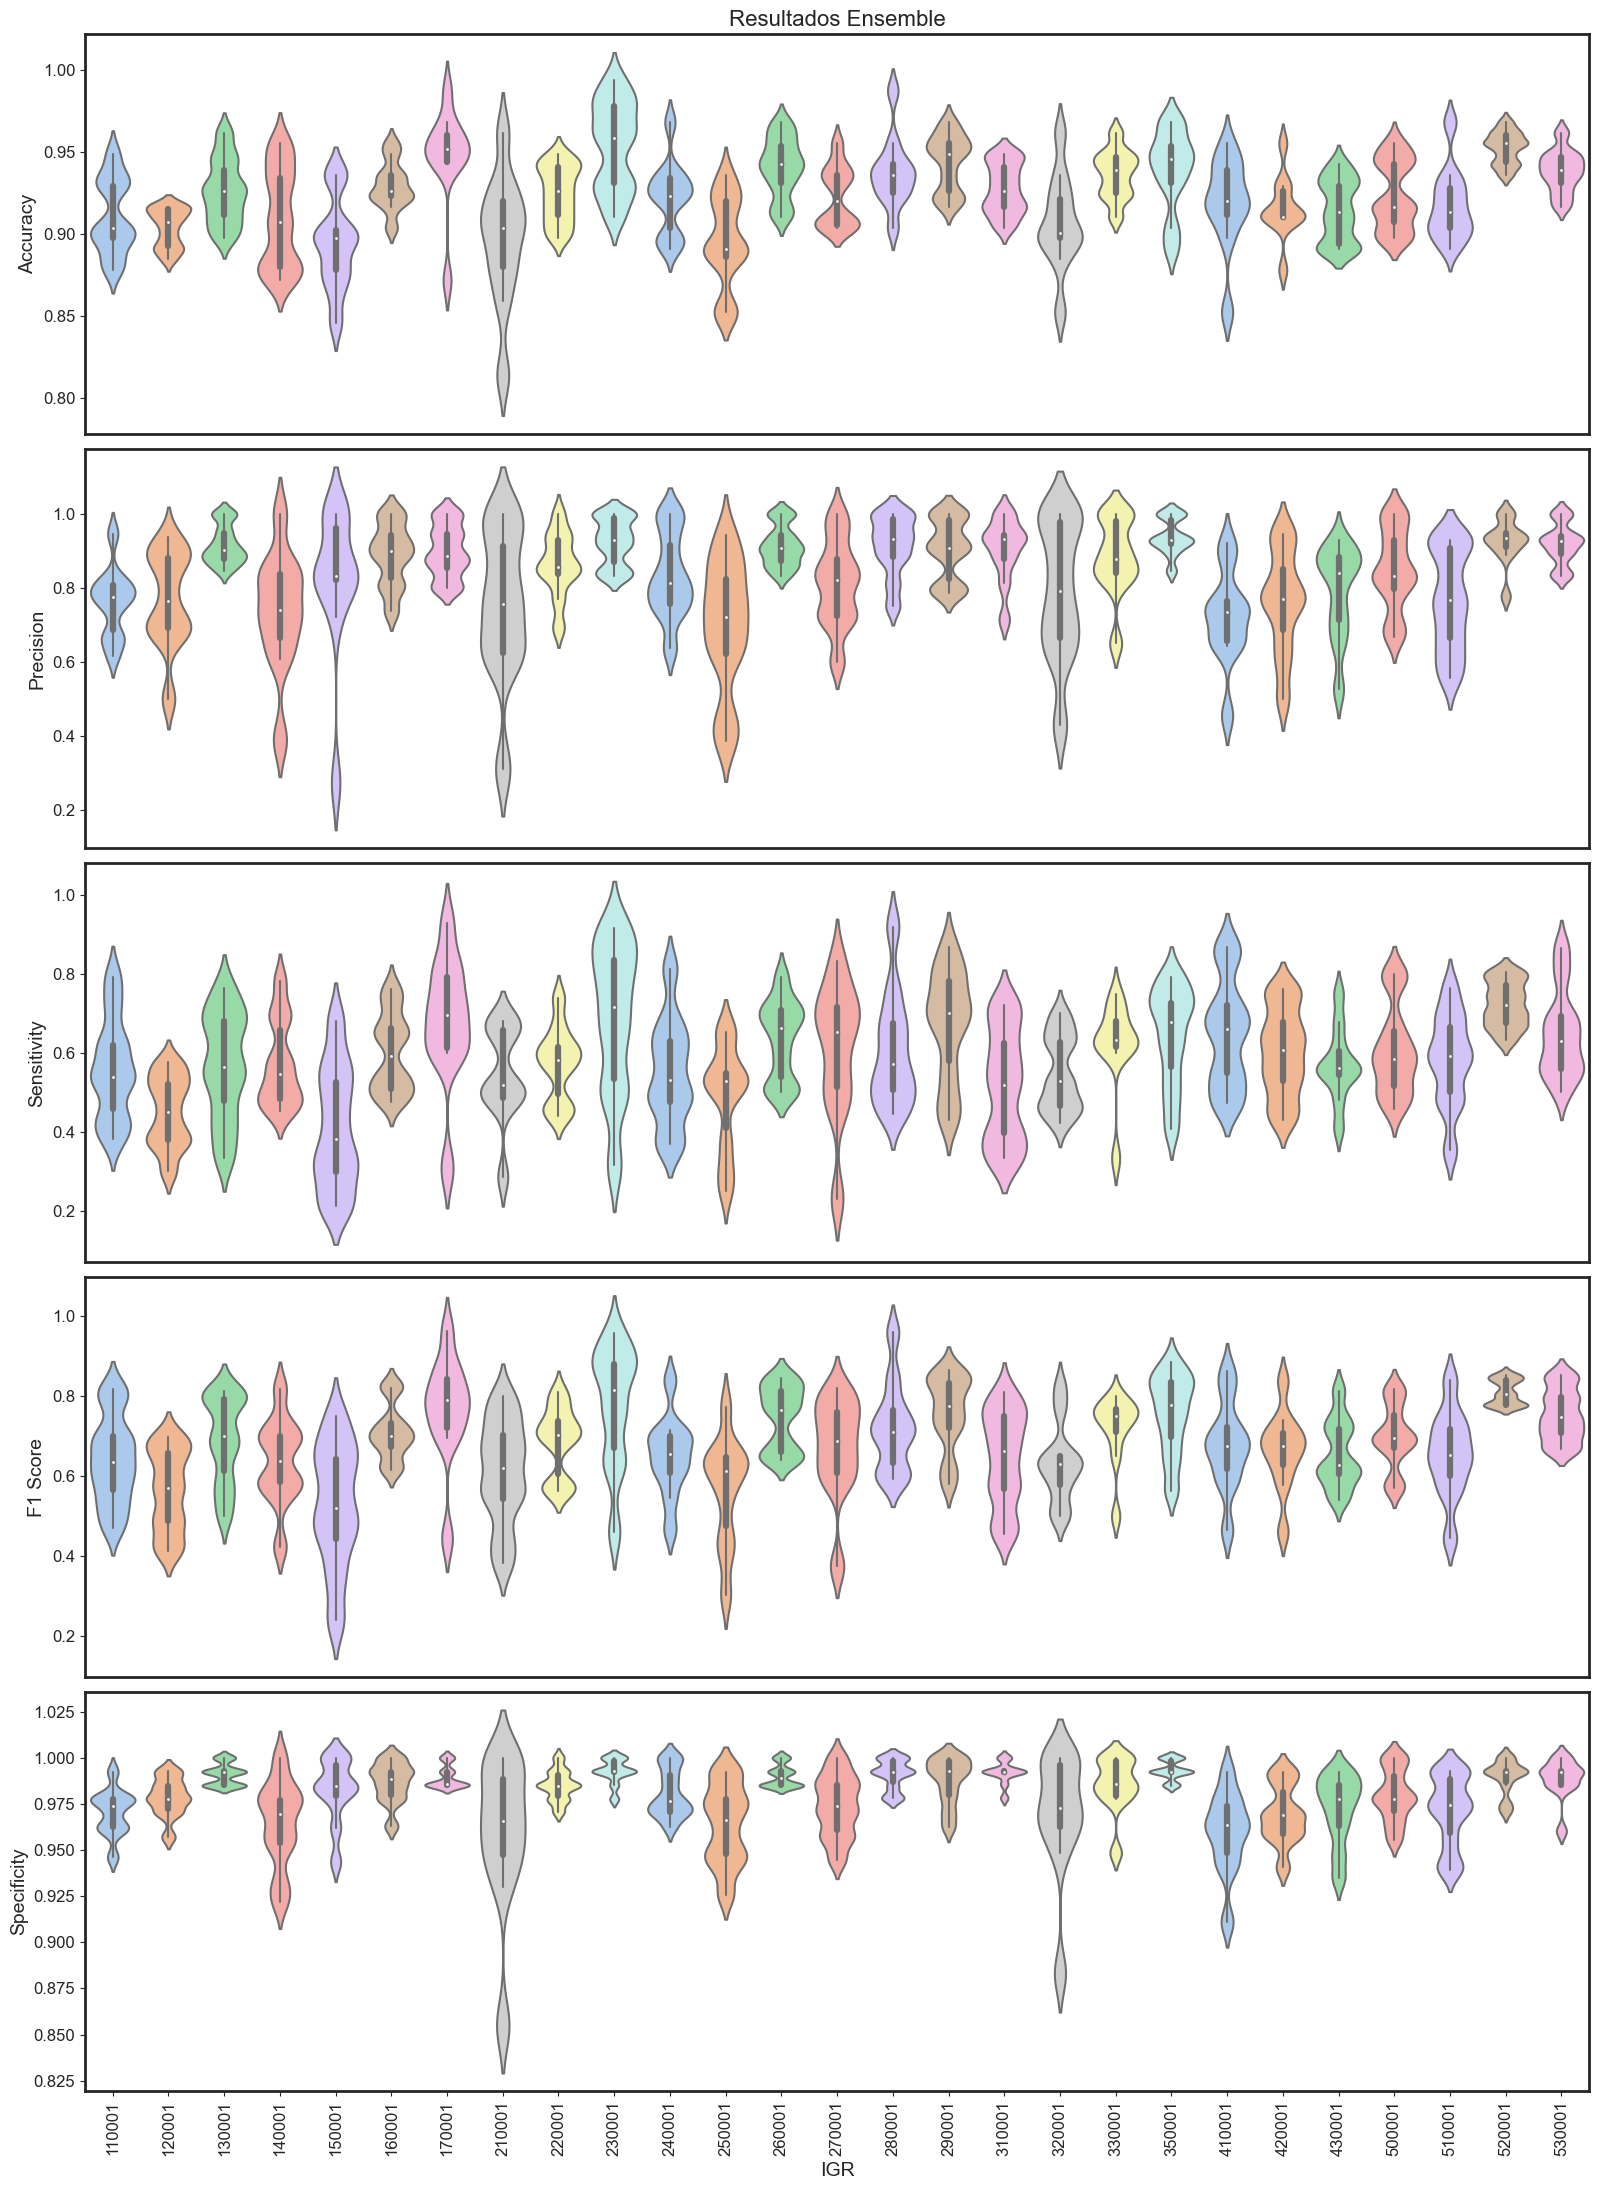

,RGI,PRECISAO_MEDIA_C1,ACURACIA_MEDIA_C1,SENSIBILIDADE_MEDIA_C1,F1_MEDIA_C1,ESPECIFICIDADE_MEDIA_C1
0,110001.0,0.961578,0.909615,0.401429,0.553780,0.996997
1,120001.0,0.947083,0.921795,0.484796,0.627774,0.995509
2,130001.0,0.977949,0.922436,0.513687,0.666242,0.997765
3,140001.0,0.968791,0.932051,0.519473,0.655020,0.997022
4,150001.0,0.966667,0.909615,0.418046,0.571602,0.998592
5,160001.0,0.973485,0.923077,0.493358,0.650119,0.997715
6,170001.0,1.000000,0.928205,0.476199,0.632556,1.000000
7,210001.0,0.952564,0.917949,0.467462,0.616622,0.996221
8,220001.0,0.982857,0.919231,0.454173,0.614960,0.998512
9,230001.0,0.960000,0.920513,0.370525,0.517427,0.997841


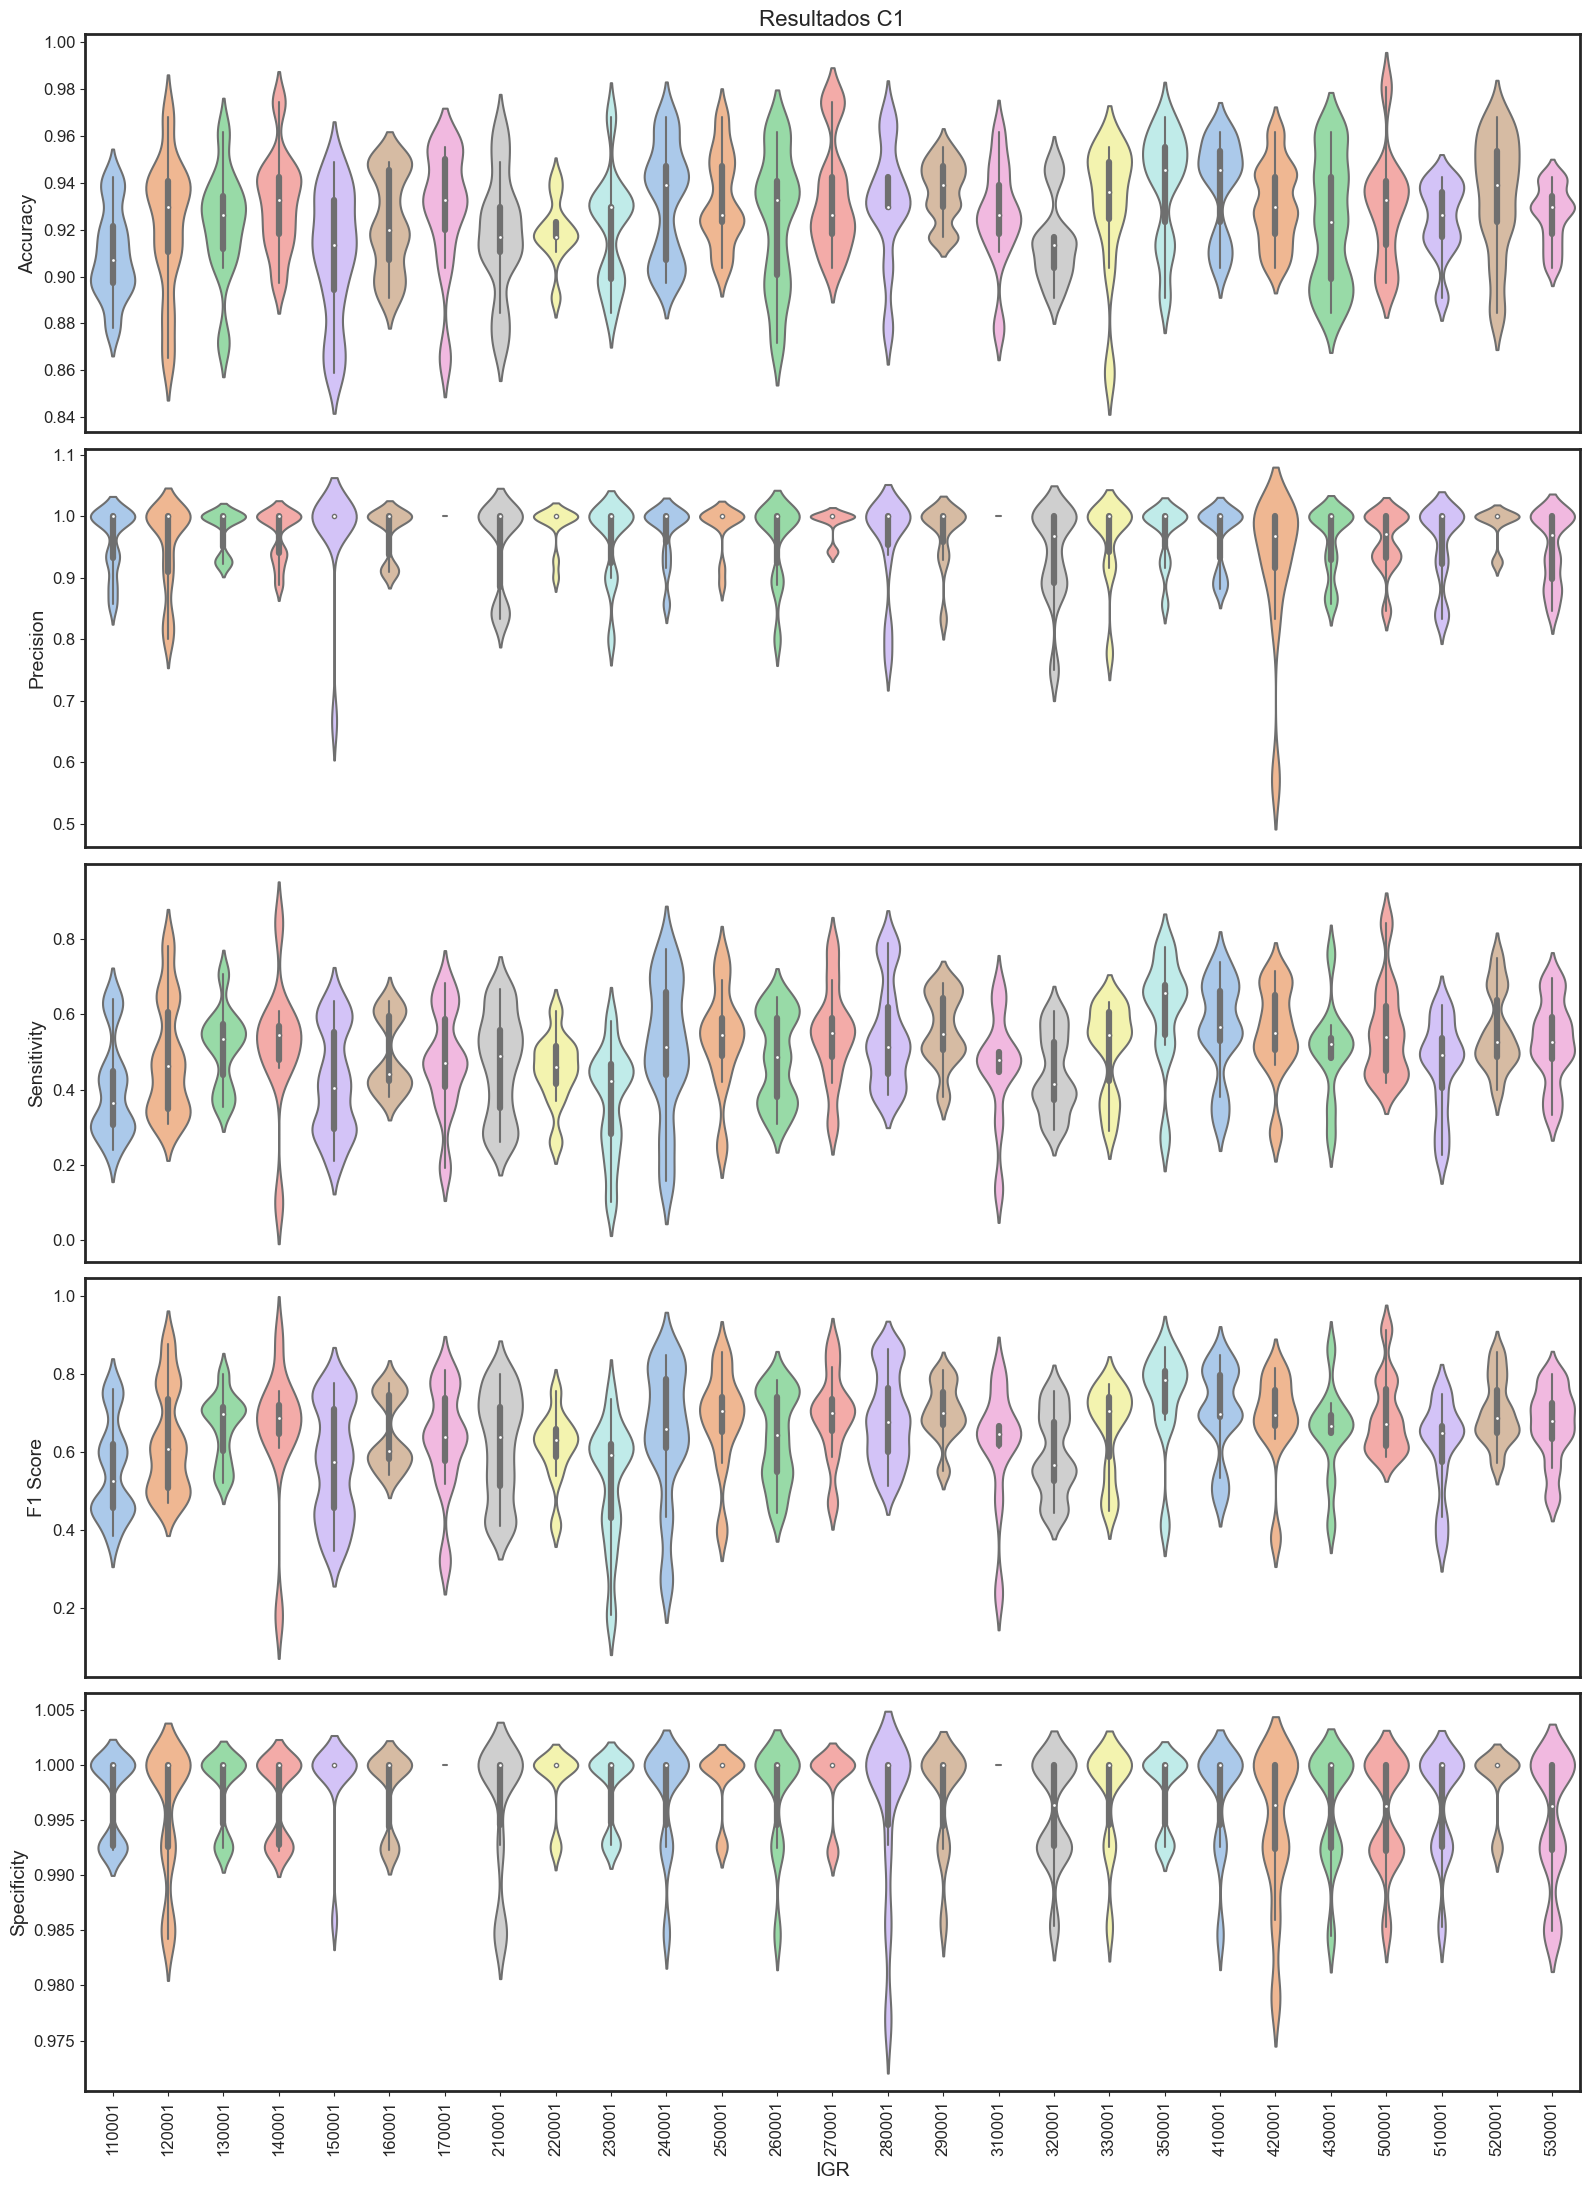

,RGI,PRECISAO_MEDIA_C2,ACURACIA_MEDIA_C2,SENSIBILIDADE_MEDIA_C2,F1_MEDIA_C2,ESPECIFICIDADE_MEDIA_C2
0,110001.0,0.914197,0.917949,0.487136,0.624920,0.991701
1,120001.0,0.868275,0.918590,0.507877,0.632266,0.987305
2,130001.0,0.900298,0.920513,0.548415,0.676180,0.988664
3,140001.0,0.892589,0.935897,0.622339,0.726001,0.987160
4,150001.0,0.869473,0.905769,0.449683,0.582900,0.988608
5,160001.0,0.859048,0.923718,0.571099,0.680927,0.984234
6,170001.0,0.829615,0.923077,0.527896,0.634563,0.985292
7,210001.0,0.846217,0.918590,0.544454,0.649474,0.983598
8,220001.0,0.867301,0.911538,0.463352,0.593740,0.987993
9,230001.0,0.807927,0.920513,0.433931,0.549377,0.989003


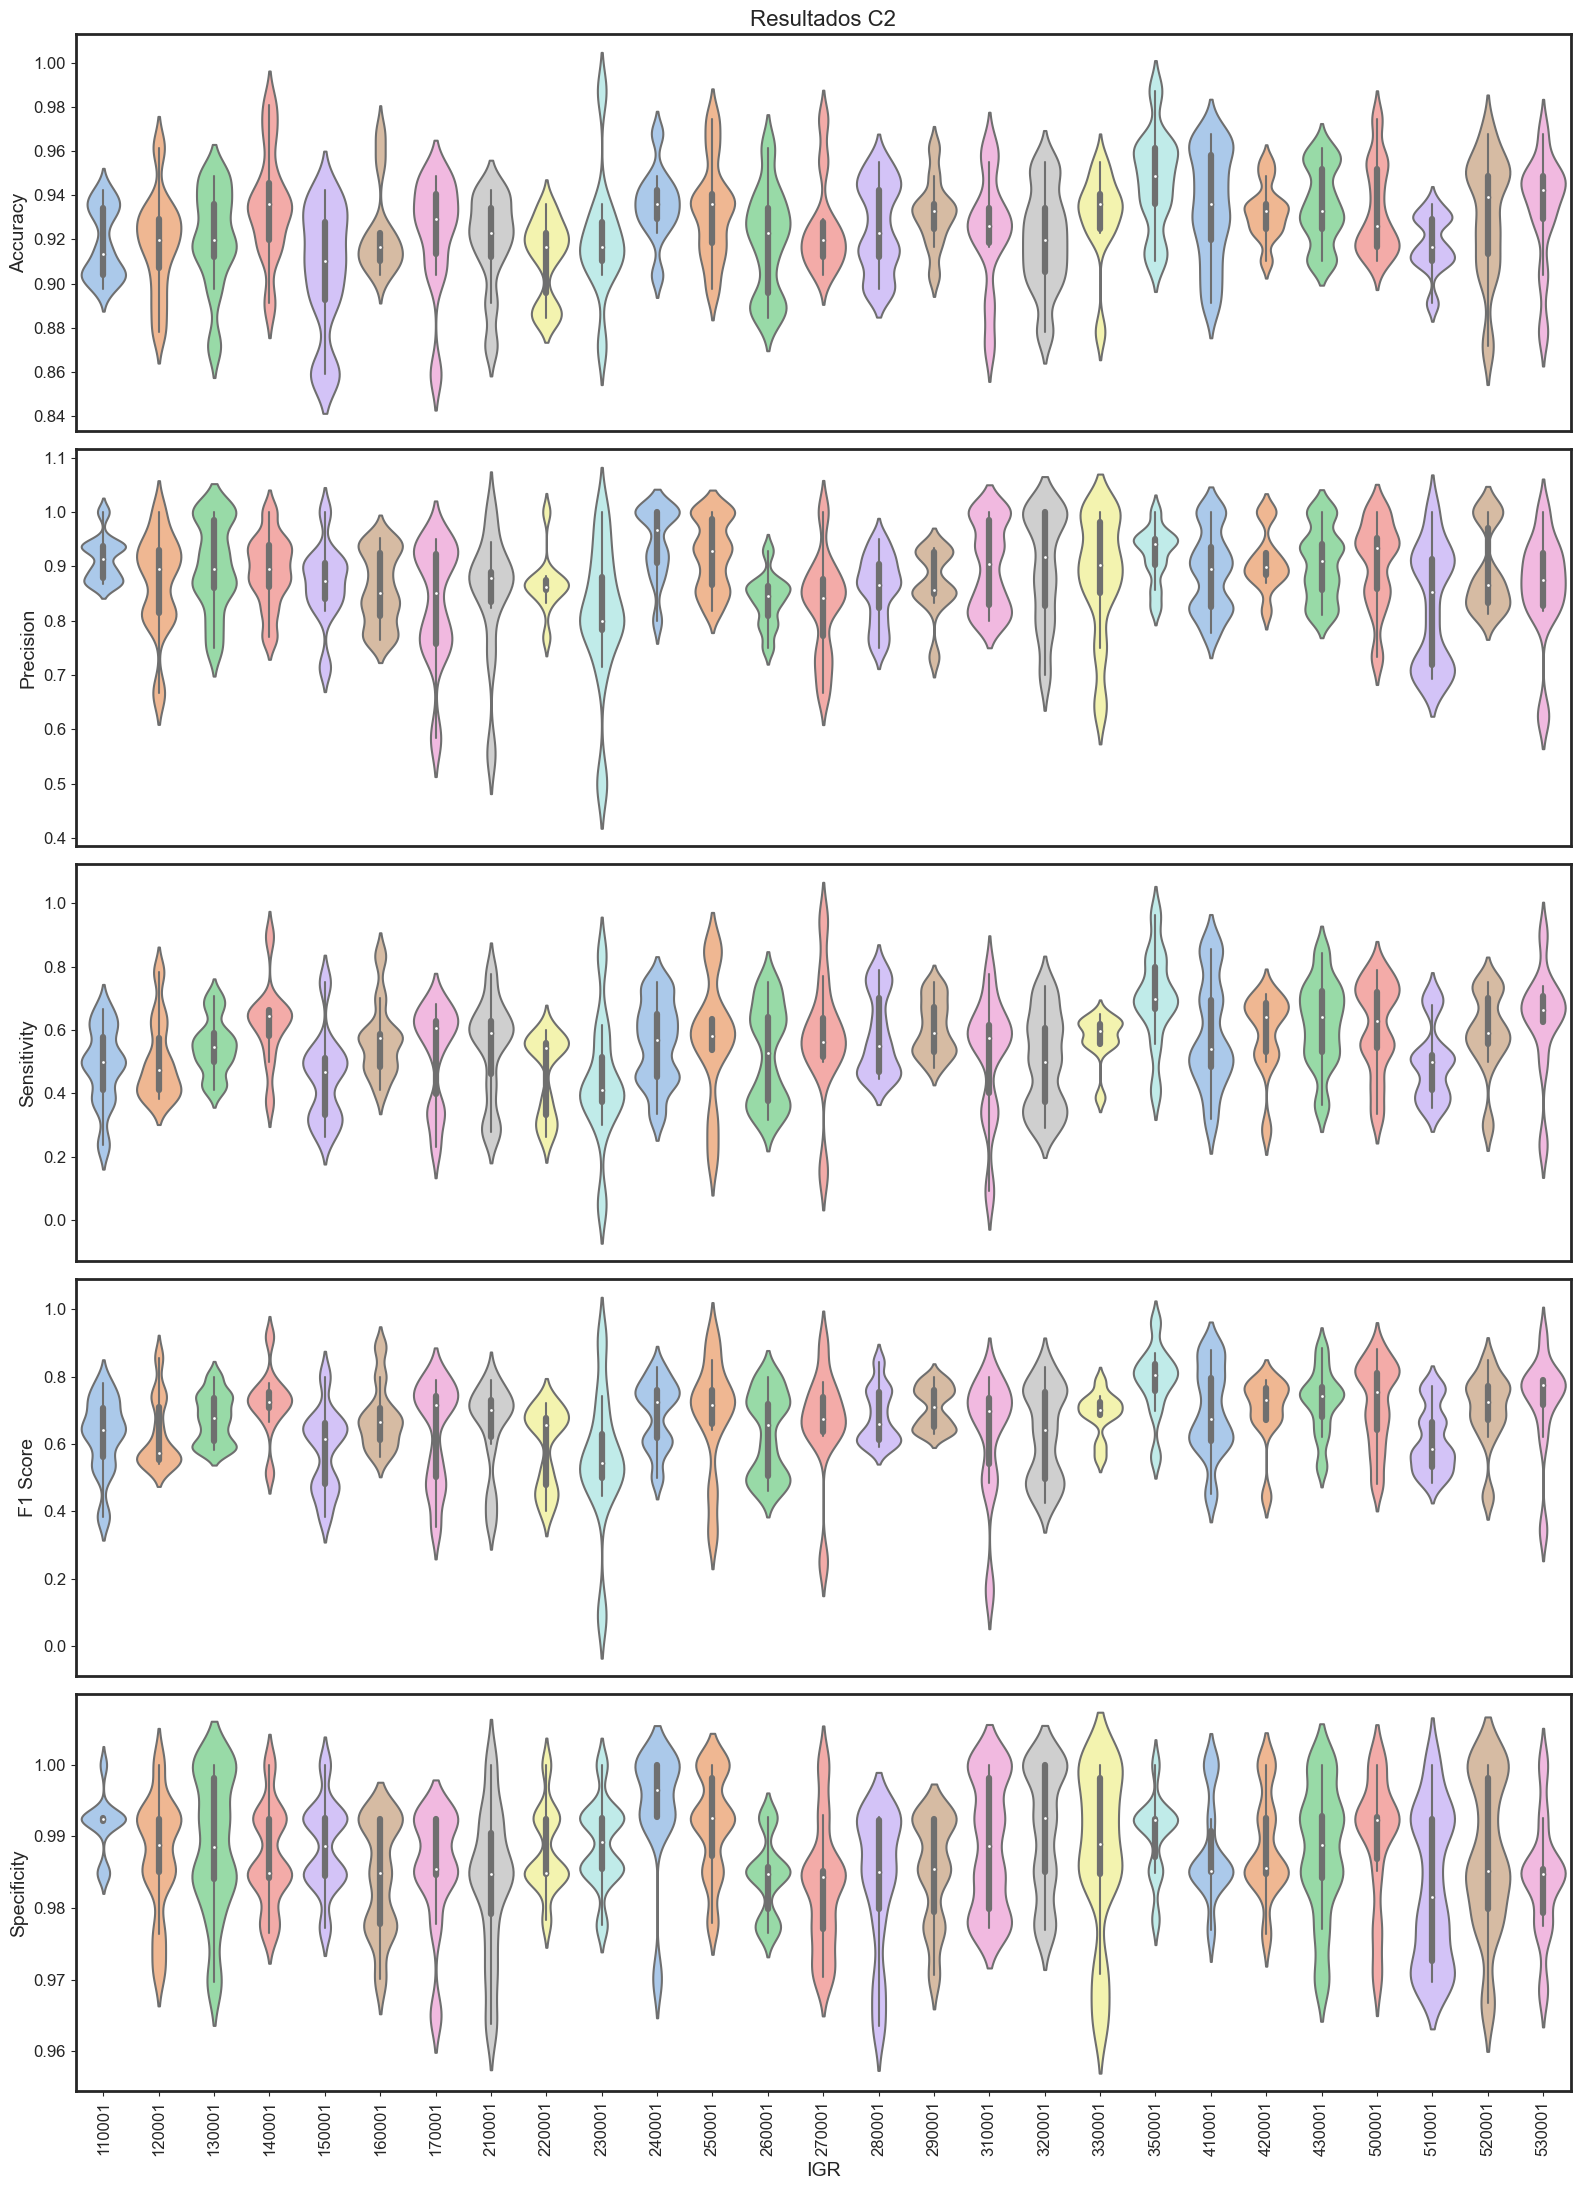

,RGI,PRECISAO_MEDIA_C3,ACURACIA_MEDIA_C3,SENSIBILIDADE_MEDIA_C3,F1_MEDIA_C3,ESPECIFICIDADE_MEDIA_C3
0,110001.0,0.631821,0.869231,0.306505,0.401446,0.965316
1,120001.0,0.619756,0.878205,0.362493,0.447266,0.964124
2,130001.0,0.657237,0.873077,0.362044,0.458502,0.966192
3,140001.0,0.662203,0.890385,0.447609,0.530795,0.962277
4,150001.0,0.618182,0.864103,0.293510,0.390333,0.970098
5,160001.0,0.645306,0.880769,0.406112,0.492703,0.962503
6,170001.0,0.545227,0.878846,0.343950,0.416116,0.961680
7,210001.0,0.658918,0.878846,0.392825,0.479283,0.963333
8,220001.0,0.565806,0.864103,0.283620,0.367020,0.962530
9,230001.0,0.480885,0.886538,0.252931,0.322824,0.974368


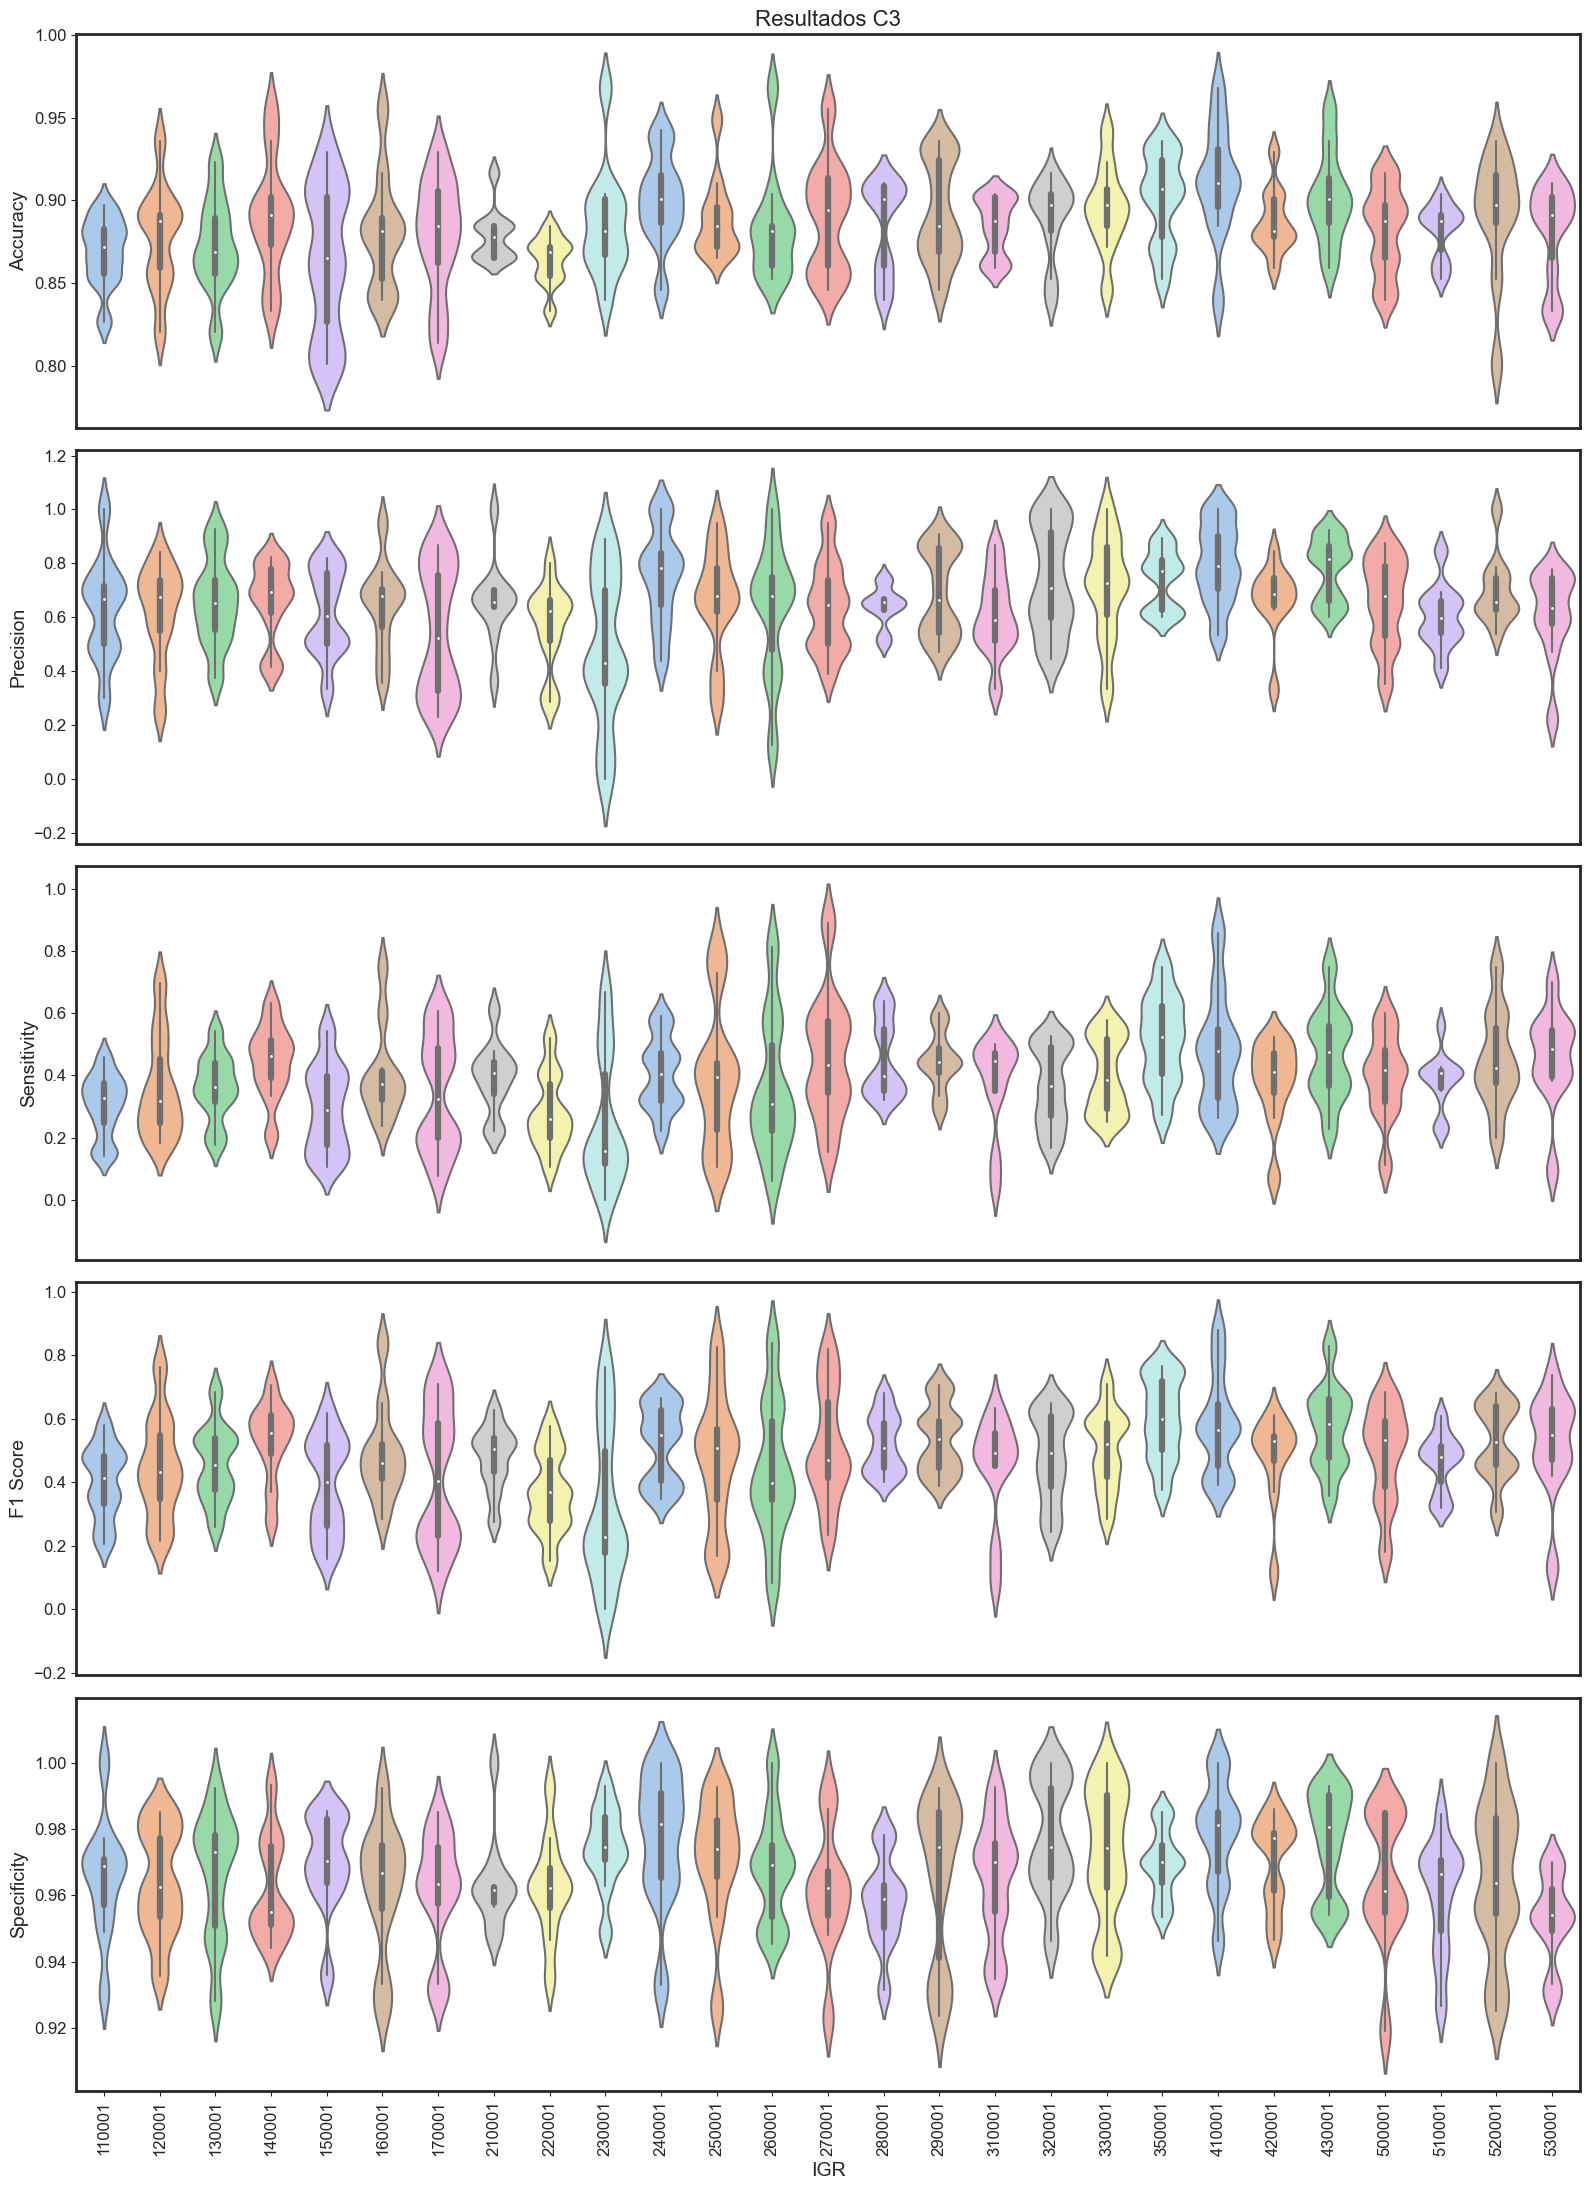

CPU times: total: 12min 40s
Wall time: 6min


In [82]:
%%time
# Suprimir avisos
warnings.filterwarnings("ignore")

# Inicializações
dadosAGP = filtraRGIs(df)

n = 10 # Número de gerações de séries sintéticas/análises para cada RGI

# DataFrame para armazenar os resultados finais
result_final = pd.DataFrame(columns=['RGI', 'PRECISAO_MEDIA', 'ACURACIA_MEDIA', 'SENSIBILIDADE_MEDIA', 'F1_MEDIA', 'ESPECIFICIDADE_MEDIA'])
result_final_C1 = pd.DataFrame(columns=['RGI', 'PRECISAO_MEDIA_C1', 'ACURACIA_MEDIA_C1', 'SENSIBILIDADE_MEDIA_C1', 'F1_MEDIA_C1', 'ESPECIFICIDADE_MEDIA_C1'])
result_final_C2 = pd.DataFrame(columns=['RGI', 'PRECISAO_MEDIA_C2', 'ACURACIA_MEDIA_C2', 'SENSIBILIDADE_MEDIA_C2', 'F1_MEDIA_C2', 'ESPECIFICIDADE_MEDIA_C2'])
result_final_C3 = pd.DataFrame(columns=['RGI', 'PRECISAO_MEDIA_C3', 'ACURACIA_MEDIA_C3', 'SENSIBILIDADE_MEDIA_C3', 'F1_MEDIA_C3', 'ESPECIFICIDADE_MEDIA_C3'])


tm = 1 # Define o tamanho da série simulada 1 = igual ao tamanho da série original, 2 = duas vezes o tamanho da série original

VEN = 0 # Verdadeiro negativo
FAP = 0 # Falso positivo
FAN = 0 # Falso negativo
VEP = 0 # Verdadeiro Positivo

MTConf = [[0,0],[0,0]] # Recebe a matriz de confusão

metricas_por_rgi = {}

metricas_por_rgi_C1 = {}
metricas_por_rgi_C2 = {}
metricas_por_rgi_C3 = {}

# Processamento para cada região
for regiao_desejada in df_RGIs:
    acuracia = []
    precisao = []
    sensibilidade = []
    f1 = []  # Inicializa a lista f1
    especificidade = []  # Inicializa a lista especificidade
    
    acuracia_C1 = []
    precisao_C1 = []
    sensibilidade_C1 = []
    f1_C1 = []
    especificidade_C1 = []  
    
    acuracia_C2 = []
    precisao_C2 = []
    sensibilidade_C2 = []
    f1_C2 = []
    especificidade_C2 = [] 
    
    acuracia_C3 = []
    precisao_C3 = []
    sensibilidade_C3 = []
    f1_C3 = []
    especificidade_C3 = [] 

    for i in range(n):
        
        

        # Filtra os dados por RGI
        df_rgi = dadosAGP[dadosAGP['cod_rgi'] == regiao_desejada]

        # divide dados para treino
        DADOS_TREINO = df_rgi[(df_rgi['ano'] >= 2017) & (df_rgi['ano'] <= 2019)]


        # Gera uma série sintética para o teste cego
        dados_noise, sintetic_data = retornaSerieSintetic(DADOS_TREINO['atend_ivas'].values, tm)

        #Cataloga a série sintética sem ruído
        dados_catalogados_sem_ruido = retornaSerieCatalogada(sintetic_data)

        #Cataloga a série sintética com ruído
        dados_catalogados_com_ruido = retornaSerieCatalogada(dados_noise)


        #-------------------// Aplica os modelos a série real e a sintética

        # Chama a função para calcular rt para série sintética com ruído
        rt_com_ruido = executeRt(dados_catalogados_com_ruido)

        # Chama a função para calcular rt para série sintética sem ruído
        rt_sem_ruido = executeRt(dados_catalogados_sem_ruido)


        #-------------normaliza dados de treino------------------------
        scaler1 = MinMaxScaler()
        dados_T = np.reshape(DADOS_TREINO['atend_ivas'].values, (-1, 1))
        dados_T = scaler1.fit_transform(dados_T)

        #-------------normaliza dados de validacao sem ruido ------------------------
        scaler2 = MinMaxScaler()
        dados_sr = np.reshape(dados_catalogados_sem_ruido['Dados_Gerados'].values, (-1, 1))
        dados_sr = scaler2.fit_transform(dados_sr)

        #-------------normaliza dados de validacao com ruido ------------------------
        scaler3 = MinMaxScaler()
        dados_cr = np.reshape(dados_catalogados_com_ruido['Dados_Gerados'].values, (-1, 1))
        dados_cr = scaler3.fit_transform(dados_cr)

        #-------- Treina os modelos de inteligência artificial --------
        ISF, LOF, OCSVM, COPO = treina_Models_ensemble(dados_T)

        #-------- Aplica a Abordagem de aprendizado de máquina nos dados sem ruído --------
        ISF_Pred_sr, LOF_Pred_sr, OCSVM_Pred_sr, COPOD_Pred_sr, ENSEMBLE_Pred_sr = executa_Models_ensemble(ISF, LOF, OCSVM, COPO, dados_sr)
        dadossr = scaler2.inverse_transform(dados_sr)

        #-------- Aplica a Abordagem de aprendizado de máquina nos dados com ruído --------
        ISF_Pred_cr, LOF_Pred_cr, OCSVM_Pred_cr, COPOD_Pred_cr, ENSEMBLE_Pred_cr =  executa_Models_ensemble(ISF, LOF, OCSVM, COPO, dados_cr)
        dadoscr = scaler3.inverse_transform(dados_cr)


        # -------- Retorna os dataframes de resultados sem ruído
        alertas_sr = retAlertas(ISF_Pred_sr, LOF_Pred_sr, OCSVM_Pred_sr, COPOD_Pred_sr, rt_sem_ruido, dadossr, dados_catalogados_sem_ruido)


        # -------- Retorna os dataframes de resultados com ruído
        alertas_cr = retAlertas(ISF_Pred_cr, LOF_Pred_cr, OCSVM_Pred_cr, COPOD_Pred_cr, rt_com_ruido, dadoscr, dados_catalogados_com_ruido)
        
        
        # ---------Obtem os índices de alerta pegos pelo Ensemble --------
        
        #---------Pega os índices do alerta sem ruído ------------
        encoder3 = LabelEncoder()
        DETEC_ENS_ALL_SR = alertas_sr['EWS_ensemble_ALL'].values
        DETEC_ENS_ALL_SR = encoder3.fit_transform(DETEC_ENS_ALL_SR)
        IND_SURTOS_ENS_SR = retINDLOF2(DETEC_ENS_ALL_SR)
       
        # ---------Pega os índices do alerta com ruído ------------
        encoder1 = LabelEncoder()

        DETEC_ENS_ALL_CR = alertas_cr['EWS_ensemble_ALL'].values
        DETEC_ENS_ALL_CR = encoder1.fit_transform(DETEC_ENS_ALL_CR)
        IND_SURTOS_ENS_CR = retINDLOF2(DETEC_ENS_ALL_CR)
    
        # ------------------------------------- Final ---------

        
        # ---------------------------Plota Detectados sem ruido  e com ruido Ensemble --------------------
        #plotGraficoSurtosDetectados(alertas_sr['Dados_Gerados'].values, IND_SURTOS_ENS_SR, regiao_desejada, 'Synthetic Series')
        #plotGraficoSurtosDetectados(alertas_cr['Dados_Gerados'].values, IND_SURTOS_ENS_CR, regiao_desejada, 'Synthetic Series with Noise')
        
        
        # ----------------------------Calcular EARs ---------------------------
        
        #valor desejado para a baseline calculo C2
        baseline_value = 8
        
        # --------------Calcular EARs Dados Sem Ruído---------------------------
        c1_stats_sr, c1_alarms_sr, c1_upperbounds_sr = calculate_c1(dadossr, baseline_value)
        IND_SURTOS_C1_SR = retINDLOF2(c1_alarms_sr)# C1 Obtem índices dos alarmes nos dados sem ruído
        
        c2_stats_sr, c2_alarms_sr, c2_upperbounds_sr = calculate_c2(dadossr, baseline_value)
        IND_SURTOS_C2_SR = retINDLOF2(c2_alarms_sr)# C2 Obtem índices dos alarmes nos dados sem ruído
        
        c3_stats_sr, c3_alarms_sr, c3_upperbounds_sr = calculate_c3(dadossr,baseline_value)
        IND_SURTOS_C3_SR = retINDLOF2(c3_alarms_sr)# C3 Obtem índices dos alarmes nos dados sem ruído
        
        
        # --------------Calcular EARs Dados com Ruído---------------------------
        c1_stats_cr, c1_alarms_cr, c1_upperbounds_cr = calculate_c1(dadoscr, baseline_value)
        IND_SURTOS_C1_CR = retINDLOF2(c1_alarms_cr)# C1 Obtem índices dos alarmes nos dados com ruído
            
        c2_stats_cr, c2_alarms_cr, c2_upperbounds_cr = calculate_c2(dadoscr, baseline_value)
        IND_SURTOS_C2_CR = retINDLOF2(c2_alarms_cr)# C2 Obtem índices dos alarmes nos dados com ruído
        
        c3_stats_cr, c3_alarms_cr, c3_upperbounds_cr = calculate_c3(dadoscr,baseline_value)
        IND_SURTOS_C3_CR = retINDLOF2(c3_alarms_cr)# C3 Obtem índices dos alarmes nos dados com ruído
        
        #------------------------------------------------------------------------
        
        # ---------------------------Plota Detectados sem ruido  e com ruido EARs --------------------
        #plotGraficoSurtosDetectados(alertas_sr['Dados_Gerados'].values,  IN_SURTOS_C1_SR, regiao_desejada, 'Dados sem ruido C1')
        #plotGraficoSurtosDetectados(alertas_sr['Dados_Gerados'].values,  IN_SURTOS_C2_SR, regiao_desejada, 'Dados sem ruido C2')
        #plotGraficoSurtosDetectados(alertas_sr['Dados_Gerados'].values,  IN_SURTOS_C2_SR, regiao_desejada, 'Dados sem ruido C3')
        
        #plotGraficoSurtosDetectados(alertas_cr['Dados_Gerados'].values, IN_SURTOS_C1_CR, regiao_desejada, 'Dados com ruido C1')
        #plotGraficoSurtosDetectados(alertas_cr['Dados_Gerados'].values, IN_SURTOS_C2_CR, regiao_desejada, 'Dados com ruido C2')
        #plotGraficoSurtosDetectados(alertas_cr['Dados_Gerados'].values, IN_SURTOS_C2_CR, regiao_desejada, 'Dados com ruido C3')
        
        
        #----------------------------Pega os pontos com Ruido para descobrir os surtos inseridos------------------------
        vtSurtosComp = retVetorSurtos(inicio_ruido, fim_ruido)# Gera um vetor completo com os pontos onde foram inseridos o ruído

        vtSurtosAlta = retINDRuidosSubida(alertas_cr['Dados_Gerados'].values, vtSurtosComp)# Gera o vetor de surtos de alta 

        #print(f'Inicio - Ruido: {inicio_ruido}')
        #print(f'\nFim - Ruido: {fim_ruido}')
        #print(f'\nVetor de ruídos completo: {vtSurtosComp}')
        #print(f'\nVetor de ruídos de alta completo: {vtSurtosAlta}')
        #print(f'\nIndices Detectados RGI sem ruido: {IND_SURTOS_ENS_SR}')
        #print(f'\nIndices Detectados RGI com ruido: {IND_SURTOS_ENS_CR}')
        
        #---------------------------- Gera o Vetor Gabarito/Vetor de verdadeiros positivos -------------------------
        ind_conj_dados = range(len(dados_catalogados_com_ruido['Dados_Gerados'])) # gera um vetor com número de índices do conjunto de validacao
        vetor_real =  gerar_vetor_binario(ind_conj_dados, vtSurtosAlta)
        
        #---------------------------- Gera o Vetor de detectados com Ensemble --------------------------------------
        posicoes_detectadas = valores_comuns(vtSurtosAlta, IND_SURTOS_ENS_CR) # retorna uma união entre os valores detectados como surtos e os surtos inseridos no conjunto de dados, basicamente pega os verdadeiros positivos detectados
        vetor_exclusivos = valores_exclusivos(IND_SURTOS_ENS_CR, vtSurtosAlta, IND_SURTOS_ENS_SR) # retorna os valores detectados como surtos que não estão contidos no vetor de ruidos/surtos inseridos, e também não estão contidos no vetor sem surtos, pega os falsos positivos
        posicoes_detectadas = sorted(posicoes_detectadas + vetor_exclusivos)
        vetor_prev =  gerar_vetor_binario(ind_conj_dados, posicoes_detectadas)
        
        # ----------------------------Gera o Vetor de detectados com EARs --------------------------------------------
        # Detectados com EARs C1 
        posicoes_detectadas_C1 = valores_comuns(vtSurtosAlta, IND_SURTOS_C1_CR) # retorna uma união entre os valores detectados como surtos e os surtos inseridos no conjunto de dados, basicamente pega os verdadeiros positivos detectados
        vetor_exclusivos_C1 = valores_exclusivos(IND_SURTOS_C1_CR, vtSurtosAlta, IND_SURTOS_C1_SR) # retorna os valores detectados como surtos que não estão contidos no vetor de ruidos/surtos inseridos, e também não estão contidos no vetor sem surtos, pega os falsos positivos
        posicoes_detectadas_C1 = sorted(posicoes_detectadas_C1 + vetor_exclusivos_C1)
        vetor_prev_C1 =  gerar_vetor_binario(ind_conj_dados, posicoes_detectadas_C1)
        
        # Detectados com EARs C2 
        posicoes_detectadas_C2 = valores_comuns(vtSurtosAlta, IND_SURTOS_C2_CR) # retorna uma união entre os valores detectados como surtos e os surtos inseridos no conjunto de dados, basicamente pega os verdadeiros positivos detectados
        vetor_exclusivos_C2 = valores_exclusivos(IND_SURTOS_C2_CR, vtSurtosAlta, IND_SURTOS_C2_SR) # retorna os valores detectados como surtos que não estão contidos no vetor de ruidos/surtos inseridos, e também não estão contidos no vetor sem surtos, pega os falsos positivos
        posicoes_detectadas_C2 = sorted(posicoes_detectadas_C2 + vetor_exclusivos_C2)
        vetor_prev_C2 =  gerar_vetor_binario(ind_conj_dados, posicoes_detectadas_C2)
        
        # Detectados com EARs C3 
        posicoes_detectadas_C3 = valores_comuns(vtSurtosAlta, IND_SURTOS_C3_CR) # retorna uma união entre os valores detectados como surtos e os surtos inseridos no conjunto de dados, basicamente pega os verdadeiros positivos detectados
        vetor_exclusivos_C3 = valores_exclusivos(IND_SURTOS_C3_CR, vtSurtosAlta, IND_SURTOS_C3_SR) # retorna os valores detectados como surtos que não estão contidos no vetor de ruidos/surtos inseridos, e também não estão contidos no vetor sem surtos, pega os falsos positivos
        posicoes_detectadas_C3 = sorted(posicoes_detectadas_C3 + vetor_exclusivos_C3)
        vetor_prev_C3 =  gerar_vetor_binario(ind_conj_dados, posicoes_detectadas_C3)
        
        
        
        # ----------------- Salva a série sintética de cada RGI do Ensemble com gabarito ----------------------------------------

        #if (regiao_desejada == 150001  or  regiao_desejada == 260001 or regiao_desejada == 310001 or regiao_desejada == 430001 or regiao_desejada == 520001):
        #    DFSINTETIC = pd.DataFrame({'SERIE_ORIGINAL': DADOS_TREINO['atend_ivas'].values, 'SERIE_SINTETICA': dados_catalogados_sem_ruido['Dados_Gerados'].values, 'SERIE_SINTETICA_COM_RUIDO': dados_catalogados_com_ruido['Dados_Gerados'].values, 'GABARITO_SURTOS': vetor_real})
            #display(DFSINTETIC)
        #    SerieSintetic = r'path'+str(regiao_desejada)+'_GERA_'+str(i+1)+'.xlsx'
        #    DFSINTETIC.to_excel(SerieSintetic, index = False)

        # -------------------------------------Fim Salva a Série ----------------------------
        
        # ----------- Calcula as métricas para o Ensemble ------------------------------------
        acuracia_atual = accuracy_score(vetor_real, vetor_prev)
        precisao_atual = precision_score(vetor_real, vetor_prev)
        sensibilidade_atual = recall_score(vetor_real, vetor_prev)
        f1_atual = f1_score(vetor_real, vetor_prev)
        matriz_confusao = confusion_matrix(vetor_real, vetor_prev)
        TN, FP, FN, TP = matriz_confusao.ravel()
        especificidade_atual = TN / (TN + FP)

        # Adiciona os resultados às listas correspondentes
        acuracia.append(acuracia_atual)
        precisao.append(precisao_atual)
        sensibilidade.append(sensibilidade_atual)
        f1.append(f1_atual)  # Corrigido aqui
        especificidade.append(especificidade_atual)

       # Após concluir todas as iterações para o RGI atual, armazena as métricas
        metricas_por_rgi[regiao_desejada] = {
        'acuracia': acuracia.copy(),
        'precisao': precisao.copy(),
        'sensibilidade': sensibilidade.copy(),
        'f1': f1.copy(),
        'especificidade': especificidade.copy()
        }
        # Imprime os resultados da iteração atual
        print('---------- Resultados Ensemble ---------- ')
        print(f"Iteração {i+1} para a região {regiao_desejada}:")
        print(f"Acurácia: {acuracia_atual:.4f}")
        print(f"Precisão: {precisao_atual:.4f}")
        print(f"Sensibilidade: {sensibilidade_atual:.4f}")
        print(f"F1 Score: {f1_atual:.4f}")
        print(f"Especificidade: {especificidade_atual:.4f}\n")
        
        # --------------------------Fim das Métricas Ensemble  ----------------------------
        
        # ----------- Calcula as métricas para EARs C1 ------------------------------------
        acuracia_atual_C1 = accuracy_score(vetor_real, vetor_prev_C1)
        precisao_atual_C1 = precision_score(vetor_real, vetor_prev_C1)
        sensibilidade_atual_C1 = recall_score(vetor_real, vetor_prev_C1)
        f1_atual_C1 = f1_score(vetor_real, vetor_prev_C1)
        matriz_confusao_C1 = confusion_matrix(vetor_real, vetor_prev_C1)
        TN_C1, FP_C1, FN_C1, TP_C1 = matriz_confusao_C1.ravel()
        especificidade_atual_C1 = TN_C1 / (TN_C1 + FP_C1)

        # Adiciona os resultados às listas correspondentes
        acuracia_C1.append(acuracia_atual_C1)
        precisao_C1.append(precisao_atual_C1)
        sensibilidade_C1.append(sensibilidade_atual_C1)
        f1_C1.append(f1_atual_C1)  # Corrigido aqui
        especificidade_C1.append(especificidade_atual_C1)

       # Após concluir todas as iterações para o RGI atual, armazena as métricas
        metricas_por_rgi_C1[regiao_desejada] = {
        'acuracia': acuracia_C1.copy(),
        'precisao': precisao_C1.copy(),
        'sensibilidade': sensibilidade_C1.copy(),
        'f1': f1_C1.copy(),
        'especificidade': especificidade_C1.copy()
        }
        # Imprime os resultados da iteração atual
        print('---------- Resultados C1 ---------- ')
        print(f"Iteração {i+1} para a região {regiao_desejada}:")
        print(f"Acurácia - C1: {acuracia_atual_C1:.4f}")
        print(f"Precisão - C1: {precisao_atual_C1:.4f}")
        print(f"Sensibilidade - C1: {sensibilidade_atual_C1:.4f}")
        print(f"F1 Score - C1: {f1_atual_C1:.4f}")
        print(f"Especificidade - C1: {especificidade_atual_C1:.4f}\n")

        # --------------------------Fim das Métricas C1  ----------------------------
        
        
        # ----------- Calcula as métricas para EARs C2 ------------------------------------
        acuracia_atual_C2 = accuracy_score(vetor_real, vetor_prev_C2)
        precisao_atual_C2 = precision_score(vetor_real, vetor_prev_C2)
        sensibilidade_atual_C2 = recall_score(vetor_real, vetor_prev_C2)
        f1_atual_C2 = f1_score(vetor_real, vetor_prev_C2)
        matriz_confusao_C2 = confusion_matrix(vetor_real, vetor_prev_C2)
        TN_C2, FP_C2, FN_C2, TP_C2 = matriz_confusao_C2.ravel()
        especificidade_atual_C2 = TN_C2 / (TN_C2 + FP_C2)

        # Adiciona os resultados às listas correspondentes
        acuracia_C2.append(acuracia_atual_C2)
        precisao_C2.append(precisao_atual_C2)
        sensibilidade_C2.append(sensibilidade_atual_C2)
        f1_C2.append(f1_atual_C2)  # Corrigido aqui
        especificidade_C2.append(especificidade_atual_C2)

       # Após concluir todas as iterações para o RGI atual, armazena as métricas
        metricas_por_rgi_C2[regiao_desejada] = {
        'acuracia': acuracia_C2.copy(),
        'precisao': precisao_C2.copy(),
        'sensibilidade': sensibilidade_C2.copy(),
        'f1': f1_C2.copy(),
        'especificidade': especificidade_C2.copy()
        }
        # Imprime os resultados da iteração atual
        print('---------- Resultados C2 ---------- ')
        print(f"Iteração {i+1} para a região {regiao_desejada}:")
        print(f"Acurácia - C2: {acuracia_atual_C2:.4f}")
        print(f"Precisão - C2: {precisao_atual_C2:.4f}")
        print(f"Sensibilidade - C2: {sensibilidade_atual_C2:.4f}")
        print(f"F1 Score - C2: {f1_atual_C2:.4f}")
        print(f"Especificidade - C2: {especificidade_atual_C2:.4f}\n")

        # --------------------------Fim das Métricas C2  ----------------------------
        
        
        # ----------- Calcula as métricas para EARs C3 ------------------------------------
        acuracia_atual_C3 = accuracy_score(vetor_real, vetor_prev_C3)
        precisao_atual_C3 = precision_score(vetor_real, vetor_prev_C3)
        sensibilidade_atual_C3 = recall_score(vetor_real, vetor_prev_C3)
        f1_atual_C3 = f1_score(vetor_real, vetor_prev_C3)
        matriz_confusao_C3 = confusion_matrix(vetor_real, vetor_prev_C3)
        TN_C3, FP_C3, FN_C3, TP_C3 = matriz_confusao_C3.ravel()
        especificidade_atual_C3 = TN_C3 / (TN_C3 + FP_C3)

        # Adiciona os resultados às listas correspondentes
        acuracia_C3.append(acuracia_atual_C3)
        precisao_C3.append(precisao_atual_C3)
        sensibilidade_C3.append(sensibilidade_atual_C3)
        f1_C3.append(f1_atual_C3)  # Corrigido aqui
        especificidade_C3.append(especificidade_atual_C3)

       # Após concluir todas as iterações para o RGI atual, armazena as métricas
        metricas_por_rgi_C3[regiao_desejada] = {
        'acuracia': acuracia_C3.copy(),
        'precisao': precisao_C3.copy(),
        'sensibilidade': sensibilidade_C3.copy(),
        'f1': f1_C3.copy(),
        'especificidade': especificidade_C3.copy()
        }
        # Imprime os resultados da iteração atual
        print('---------- Resultados C3 ---------- ')
        print(f"Iteração {i+1} para a região {regiao_desejada}:")
        print(f"Acurácia - C3: {acuracia_atual_C3:.4f}")
        print(f"Precisão - C3: {precisao_atual_C3:.4f}")
        print(f"Sensibilidade - C3: {sensibilidade_atual_C3:.4f}")
        print(f"F1 Score - C3: {f1_atual_C3:.4f}")
        print(f"Especificidade - C3: {especificidade_atual_C3:.4f}\n")

        # --------------------------Fim das Métricas C3  ----------------------------
        
        
        # Acumula valores para montar a Matriz de confusão
        VEN = VEN+TN
        FAP = FAP+FP
        FAN = FAN+FN
        VEP = VEP+TP
        
        # Zera os vetores de inicio e fim de ruido
        inicio_ruido = []
        fim_ruido = []

    

    # Atribui os valores para montar a matriz de confusão
    MTConf[0][0] = VEN
    MTConf[0][1] = FAP
    MTConf[1][0] = FAN
    MTConf[1][1] = VEP


    #--------------Plota a Matriz de confusão----------------------
    #plotMatrizConfMD(MTConf, regiao_desejada)

    VEN = 0
    FAP = 0
    FAN = 0
    VEP = 0

    MTConf[0][0] = 0
    MTConf[0][1] = 0
    MTConf[1][0] = 0
    MTConf[1][1] = 0


    #--------------- Calcula a média das métricas de cada RGI para o Ensemble ------------
    acuracia_media = np.mean(acuracia)
    precisao_media = np.mean(precisao)
    sensibilidade_media = np.mean(sensibilidade)
    f1_media = np.mean(f1)
    especificidade_media = np.mean(especificidade)

    # Adiciona os resultados no DataFrame final
    result_final = result_final.append({
        'RGI': regiao_desejada,
        'PRECISAO_MEDIA': precisao_media,
        'ACURACIA_MEDIA': acuracia_media,
        'SENSIBILIDADE_MEDIA': sensibilidade_media,
        'F1_MEDIA': f1_media,
        'ESPECIFICIDADE_MEDIA': especificidade_media
    }, ignore_index=True)
    
    #--------------- Fim calcula a media do Ensemble ------------
    
    
    #--------------- Calcula a média das métricas de cada RGI para o EARs C1 ------------
    acuracia_media_C1 = np.mean(acuracia_C1)
    precisao_media_C1 = np.mean(precisao_C1)
    sensibilidade_media_C1 = np.mean(sensibilidade_C1)
    f1_media_C1 = np.mean(f1_C1)
    especificidade_media_C1 = np.mean(especificidade_C1)

    # Adiciona os resultados no DataFrame final
    result_final_C1 = result_final_C1.append({
        'RGI': regiao_desejada,
        'PRECISAO_MEDIA_C1': precisao_media_C1,
        'ACURACIA_MEDIA_C1': acuracia_media_C1,
        'SENSIBILIDADE_MEDIA_C1': sensibilidade_media_C1,
        'F1_MEDIA_C1': f1_media_C1,
        'ESPECIFICIDADE_MEDIA_C1': especificidade_media_C1
    }, ignore_index=True)
    
    #--------------- Fim calcula a media do EARs C1 ------------
    
    
    #--------------- Calcula a média das métricas de cada RGI para o EARs C2 ------------
    acuracia_media_C2 = np.mean(acuracia_C2)
    precisao_media_C2 = np.mean(precisao_C2)
    sensibilidade_media_C2 = np.mean(sensibilidade_C2)
    f1_media_C2 = np.mean(f1_C2)
    especificidade_media_C2 = np.mean(especificidade_C2)

    # Adiciona os resultados no DataFrame final
    result_final_C2 = result_final_C2.append({
        'RGI': regiao_desejada,
        'PRECISAO_MEDIA_C2': precisao_media_C2,
        'ACURACIA_MEDIA_C2': acuracia_media_C2,
        'SENSIBILIDADE_MEDIA_C2': sensibilidade_media_C2,
        'F1_MEDIA_C2': f1_media_C2,
        'ESPECIFICIDADE_MEDIA_C2': especificidade_media_C2
    }, ignore_index=True)
    
    #--------------- Fim calcula a media do EARs C2 ------------
    
    
    #--------------- Calcula a média das métricas de cada RGI para o EARs C3 ------------
    acuracia_media_C3 = np.mean(acuracia_C3)
    precisao_media_C3 = np.mean(precisao_C3)
    sensibilidade_media_C3 = np.mean(sensibilidade_C3)
    f1_media_C3 = np.mean(f1_C3)
    especificidade_media_C3 = np.mean(especificidade_C3)

    # Adiciona os resultados no DataFrame final
    result_final_C3 = result_final_C3.append({
        'RGI': regiao_desejada,
        'PRECISAO_MEDIA_C3': precisao_media_C3,
        'ACURACIA_MEDIA_C3': acuracia_media_C3,
        'SENSIBILIDADE_MEDIA_C3': sensibilidade_media_C3,
        'F1_MEDIA_C3': f1_media_C3,
        'ESPECIFICIDADE_MEDIA_C3': especificidade_media_C3
    }, ignore_index=True)
    
    #--------------- Fim calcula a media do EARs C3 ------------
    
    
    # ------------- Reseta as listas de métricas para a próxima região ------------------
    acuracia = []
    precisao = []
    sensibilidade = []
    f1 = []
    especificidade = []
    
    acuracia_C1 = []
    precisao_C1 = []
    sensibilidade_C1 = []
    f1_C1 = []
    especificidade_C1 = []  
    
    acuracia_C2 = []
    precisao_C2 = []
    sensibilidade_C2 = []
    f1_C2 = []
    especificidade_C2 = [] 
    
    acuracia_C3 = []
    precisao_C3 = []
    sensibilidade_C3 = []
    f1_C3 = []
    especificidade_C3 = [] 
    
    #-----------------------------Reset Métricas ---------------------------------------

# ---------------- Exibe o DataFrame final com as médias das métricas para o Ensemble -------------------

display(result_final)
result_final.to_excel('Resultado_Final_ENS.xlsx', index = False)

# ------------------------------------------Fim Exibe DataFrame Ensemble ------------------------

# Define as Configurações de estilo do Seaborn
sns.set_style("ticks")

# -------------- Plota Resultados do Ensemble - Grafico de violino --------------------------------------------
rgi_data = pd.DataFrame()
for rgi, metrics in metricas_por_rgi.items():
    for metric_name, values in metrics.items():
        temp_df = pd.DataFrame({
            'RGI': rgi,
            'Metric': metric_name,
            'Value': values
        })
        rgi_data = pd.concat([rgi_data, temp_df], ignore_index=True)

#nomenclaturas em inglês
metric_names_mapping = {
    'acuracia': 'Accuracy',
    'precisao': 'Precision',
    'sensibilidade': 'Sensitivity',
    'f1': 'F1 Score',
    'especificidade': 'Specificity'
}

fig, axs = plt.subplots(nrows = 5, figsize=(16, 22))  # dimensão
axs[0].set_title('Resultados Ensemble', fontsize=16) 
for i, (metric_pt, metric_en) in enumerate(metric_names_mapping.items()):
    sns.violinplot(x='RGI', y='Value', data=rgi_data[rgi_data['Metric'] == metric_pt], ax=axs[i], palette='pastel', inner='box', bw=0.3, cut=2, scale='count')
    #axs[i].set_title(metric_en, fontsize=16)  # Usa título em inglês
    axs[i].set_xlabel('IGR', fontsize=14)
    axs[i].set_ylabel(metric_en, fontsize=14)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    
     # Definir a espessura do contorno para cada subplot
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)  # Defina o valor que desejar
        
for i in range(5):
    if(i < 5-1):
        axs[i].xaxis.set_visible(False)    
    
plt.tight_layout()
plt.show()

# ------------------------- Fim Plota Resultados do Ensenble --------------------------


# ---------------- Exibe o DataFrame final com as médias das métricas para o EARs C1 -------------------

display(result_final_C1)
result_final_C1.to_excel('Resultado_Final_C1.xlsx', index = False)

# ------------------------------------------Fim Exibe DataFrame EARs C1------------------------


# -------------- Plota Resultados do EARs C1 - Grafico de violino --------------------------------------------
rgi_data_C1 = pd.DataFrame()
for rgi_C1, metrics_C1 in metricas_por_rgi_C1.items():
    for metric_name, values in metrics_C1.items():
        temp_df_C1 = pd.DataFrame({
            'RGI': rgi_C1,
            'Metric': metric_name,
            'Value': values
        })
        rgi_data_C1 = pd.concat([rgi_data_C1, temp_df_C1], ignore_index=True)

#nomenclaturas em inglês
metric_names_mapping_C1 = {
    'acuracia': 'Accuracy',
    'precisao': 'Precision',
    'sensibilidade': 'Sensitivity',
    'f1': 'F1 Score',
    'especificidade': 'Specificity'
}

fig, axs = plt.subplots(nrows = 5, figsize=(16, 22))  # dimensão
axs[0].set_title('Resultados C1', fontsize=16) 
for i, (metric_pt_C1, metric_en_C1) in enumerate(metric_names_mapping_C1.items()):
    sns.violinplot(x='RGI', y='Value', data=rgi_data_C1[rgi_data_C1['Metric'] == metric_pt_C1], ax=axs[i], palette='pastel', inner='box', bw=0.3, cut=2, scale='count')
    #axs[i].set_title(metric_en, fontsize=16)  # Usa título em inglês
    axs[i].set_xlabel('IGR', fontsize=14)
    axs[i].set_ylabel(metric_en_C1, fontsize=14)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)  # Defina o valor que desejar
        
for i in range(5):
    if(i < 5-1):
        axs[i].xaxis.set_visible(False)    
    
plt.tight_layout()
plt.show()

# -------------------------Fim Plota Resultados do EARs C1 --------------------------


# ---------------- Exibe o DataFrame final com as médias das métricas para o EARs C2 -------------------

display(result_final_C2)
result_final_C2.to_excel('Resultado_Final_C2.xlsx', index = False)

# ------------------------------------------Fim Exibe DataFrame EARs C2------------------------


# -------------- Plota Resultados do EARs C2 - Grafico de violino --------------------------------------------
rgi_data_C2 = pd.DataFrame()
for rgi_C2, metrics_C2 in metricas_por_rgi_C2.items():
    for metric_name, values in metrics_C2.items():
        temp_df_C2 = pd.DataFrame({
            'RGI': rgi_C2,
            'Metric': metric_name,
            'Value': values
        })
        rgi_data_C2 = pd.concat([rgi_data_C2, temp_df_C2], ignore_index=True)

#nomenclaturas em inglês
metric_names_mapping_C2 = {
    'acuracia': 'Accuracy',
    'precisao': 'Precision',
    'sensibilidade': 'Sensitivity',
    'f1': 'F1 Score',
    'especificidade': 'Specificity'
}

fig, axs = plt.subplots(nrows = 5, figsize=(16, 22))  # dimensão
axs[0].set_title('Resultados C2', fontsize=16) 
for i, (metric_pt_C2, metric_en_C2) in enumerate(metric_names_mapping_C2.items()):
    sns.violinplot(x='RGI', y='Value', data=rgi_data_C2[rgi_data_C2['Metric'] == metric_pt_C2], ax=axs[i], palette='pastel', inner='box', bw=0.3, cut=2, scale='count')
    #axs[i].set_title(metric_en, fontsize=16)  # Usa título em inglês
    axs[i].set_xlabel('IGR', fontsize=14)
    axs[i].set_ylabel(metric_en_C2, fontsize=14)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)  # Defina o valor que desejar
        
for i in range(5):
    if(i < 5-1):
        axs[i].xaxis.set_visible(False)    
    
plt.tight_layout()
plt.show()

# -------------------------Fim Plota Resultados do EARs C2 --------------------------


# ---------------- Exibe o DataFrame final com as médias das métricas para o EARs C3 -------------------

display(result_final_C3)
result_final_C3.to_excel('Resultado_Final_C3.xlsx', index = False)

# ------------------------------------------Fim Exibe DataFrame EARs C3------------------------


# -------------- Plota Resultados do EARs C3 - Grafico de violino --------------------------------------------
rgi_data_C3 = pd.DataFrame()
for rgi_C3, metrics_C3 in metricas_por_rgi_C3.items():
    for metric_name, values in metrics_C3.items():
        temp_df_C3 = pd.DataFrame({
            'RGI': rgi_C3,
            'Metric': metric_name,
            'Value': values
        })
        rgi_data_C3 = pd.concat([rgi_data_C3, temp_df_C3], ignore_index=True)

#nomenclaturas em inglês
metric_names_mapping_C3 = {
    'acuracia': 'Accuracy',
    'precisao': 'Precision',
    'sensibilidade': 'Sensitivity',
    'f1': 'F1 Score',
    'especificidade': 'Specificity'
}

fig, axs = plt.subplots(nrows = 5, figsize=(16, 22))  # dimensão
axs[0].set_title('Resultados C3', fontsize=16) 
for i, (metric_pt_C3, metric_en_C3) in enumerate(metric_names_mapping_C3.items()):
    sns.violinplot(x='RGI', y='Value', data=rgi_data_C3[rgi_data_C3['Metric'] == metric_pt_C3], ax=axs[i], palette='pastel', inner='box', bw=0.3, cut=2, scale='count')
    axs[i].set_xlabel('IGR', fontsize=14)
    axs[i].set_ylabel(metric_en_C3, fontsize=14)
    axs[i].tick_params(axis='x', labelsize=12)
    axs[i].tick_params(axis='y', labelsize=12)
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=90)
    
    for spine in axs[i].spines.values():
        spine.set_linewidth(2)  # Defina o valor que desejar
        
for i in range(5):
    if(i < 5-1):
        axs[i].xaxis.set_visible(False)    
    
plt.tight_layout()
plt.show()


In [83]:
rgi_data.to_excel('Metricas_CONF_2.xlsx', index = False)